anergy drivers of energy use in cities across scales

# SET-UP

In [499]:
#####################
####Load Packages####
#####################

library(ggplot2)
library(plyr)
library(googlesheets)
library(dplyr)
library(data.table)
library(corrplot)
library(cowplot)
library(grid)
library(RColorBrewer)
library(apsrtable)
library(stargazer)
library(data.table)

In [33]:
######################
###### FUNCTIONS #####
######################

#ref: http://www.gettinggeneticsdone.com/2011/01/rstats-function-for-extracting-f-test-p.html
lmp <- function (modelobject) {
    if (class(modelobject) != "lm") stop("Not an object of class 'lm' ")
    f <- summary(modelobject)$fstatistic
    p <- pf(f[1],f[2],f[3],lower.tail=F)
    attributes(p) <- NULL
    return(p)
}



# DATA PREAPARATION

In [4]:
#####################
####  Load Data  ####
#####################

cisbat_raw <- fread('https://docs.google.com/spreadsheets/d/17doFqXCwiFDG1yWpulf_3FMXsNyZlBHmBKS3pE1gl_o/pub?gid=1141198192&single=true&output=csv')



In [5]:
#####################
#### Rename Data ####
#####################

colnames(cisbat_raw) <- c("city", "mtu", "electricityUse_mwh", 
                          "residencialElectricityUse_mwh", "naturalGasUse_mwh",
                          "population", "density",
                          "householdIncome_usd", "householdIncome_PPP", 
                          "trash1", "trash2", "trash3", "trash4", "trash5", "trash6")


cisbat <- subset(cisbat_raw, select=c("city", "mtu", "electricityUse_mwh", 
                                      "residencialElectricityUse_mwh", "naturalGasUse_mwh",
                                      "population", "density",
                                      "householdIncome_usd", "householdIncome_PPP"))



In [6]:
#####################################
#### Calculate Per Capita Values ####
#####################################

cisbat$naturalGasUse_percapita_mwh <- cisbat$naturalGasUse_mwh / cisbat$population
cisbat$electricityUse_percapita_mwh <- cisbat$electricityUse_mwh / cisbat$population
cisbat$residencialElectricityUse_percapita_mwh <- cisbat$residencialElectricityUse_mwh / cisbat$population


In [7]:
#######################
#### Abbreviations ####
#######################


original<-c('city',
'mtu',
'electricityUse_mwh',
'residencialElectricityUse_mwh',
'naturalGasUse_mwh' ,
'population' ,
'density', 
'householdIncome_usd',
'householdIncome_PPP',
'naturalGasUse_percapita_mwh',
'electricityUse_percapita_mwh',
'residencialElectricityUse_percapita_mwh')


abbreviation<-c('city',
'mtu',
"EU",
"REU",
"NGU",
"pop",
"density", 
"income_usd",
"income",
"NGUpc",
"EUpc",
"REUpc")

names <- data.frame(original, abbreviation)
names

original,abbreviation
city,city
mtu,mtu
electricityUse_mwh,EU
residencialElectricityUse_mwh,REU
naturalGasUse_mwh,NGU
population,pop
density,density
householdIncome_usd,income_usd
householdIncome_PPP,income
naturalGasUse_percapita_mwh,NGUpc


In [194]:
######################################
####   Set the Cities as Levels   ####
######################################

levels(cisbat$city) <- unique(cisbat$city)

myColors <- brewer.pal(10,"Paired")
names(myColors) <- levels(cisbat$city)
colScale <- scale_colour_manual(name = "city",values = myColors)
filScale <- scale_fill_manual(name = "city",values = myColors)

In [9]:
########################
###### Cleaning ########
########################
nrow(cisbat)
cisbat <- subset(cisbat, !(city=="Chicago" & electricityUse_mwh==0))
#cisbat <- subset(cisbat, !(city=="Chicago" & residencialElectricityUse_mwh==0))
nrow(cisbat)
cisbat <- subset(cisbat, !(city=="San Francisco" & electricityUse_mwh==0))
nrow(cisbat)
cisbat <- subset(cisbat, !(city=="San Francisco" & naturalGasUse_percapita_mwh==0))
nrow(cisbat)
cisbat <- subset(cisbat, !(city=="Los Angeles" & householdIncome_usd==0))
#cisbat <- subset(cisbat, !(city=="Cape Town" & electricityUse_mwh==0))
nrow(cisbat)
cisbat <- subset(cisbat, !(city=="Cape Town" & residencialElectricityUse_mwh==0))
nrow(cisbat)
cisbat <- subset(cisbat, !(city=="New York City" & population==0))
#cisbat <- subset(cisbat, !(city=="Glasgow"))
nrow(cisbat)

[1] 903

[1] 893

[1] 889

[1] 889

[1] 875

[1] 846

[1] 796

In [486]:
# ref: https://stackoverflow.com/questions/14477001/r-aggregating-multiple-variables-with-different-functions
# mean or median?
cisbat.dt <- data.table(cisbat)
cisbat.dt <- cisbat.dt[, list( electricityUse_mwh=sum(electricityUse_mwh), 
                               residencialElectricityUse_mwh=sum(residencialElectricityUse_mwh),
                               naturalGasUse_mwh=sum(naturalGasUse_mwh),
                               population=sum(population),
                               density=mean(density),
                               householdIncome_PPP=mean(householdIncome_PPP),
                               naturalGasUse_percapita_mwh=mean(naturalGasUse_percapita_mwh),
                               naturalGasUse_mwh=mean(naturalGasUse_mwh),
                               residencialElectricityUse_percapita_mwh=mean(residencialElectricityUse_percapita_mwh)),
                  by=c("city")]
cisbat_city <- data.frame(cisbat.dt)

# EXPLORATORY DATA  ANALYSIS

In [13]:
##########################
###### occurences ########
##########################
data.frame(table(cisbat$city))

Var1,Freq
Brussels,19
Buenos Aires,25
Cape Town,82
Chicago,58
Glasgow,133
London,33
Los Angeles,109
Milan,134
New York City,180
San Francisco,23


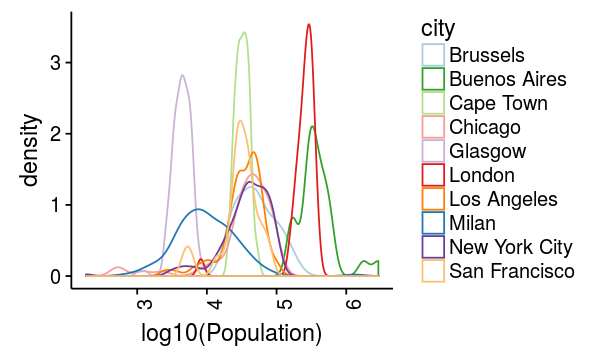

Warning message:
“Removed 26 rows containing non-finite values (stat_density).”

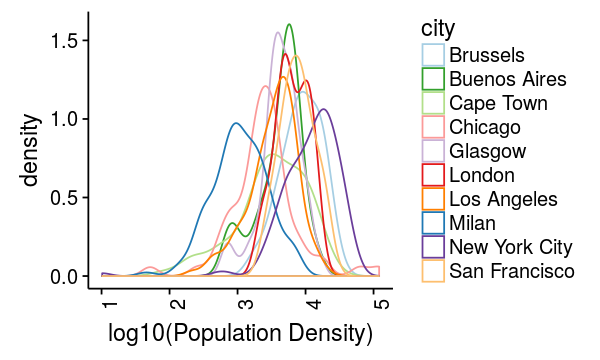

Warning message:
“Removed 350 rows containing non-finite values (stat_density).”

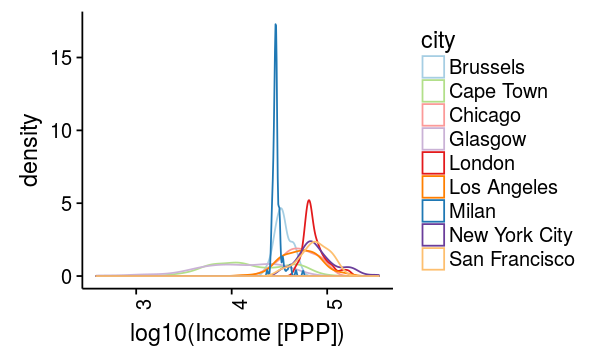

Warning message:
“Removed 371 rows containing non-finite values (stat_density).”

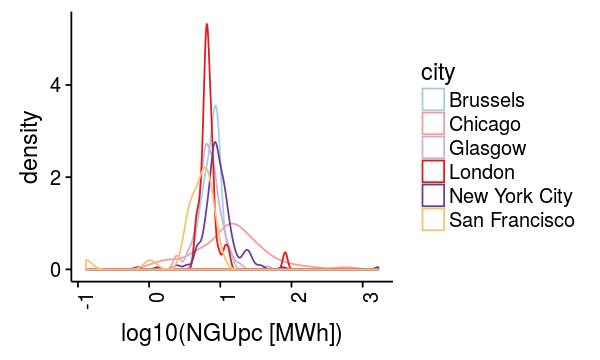

Warning message:
“Removed 261 rows containing non-finite values (stat_density).”

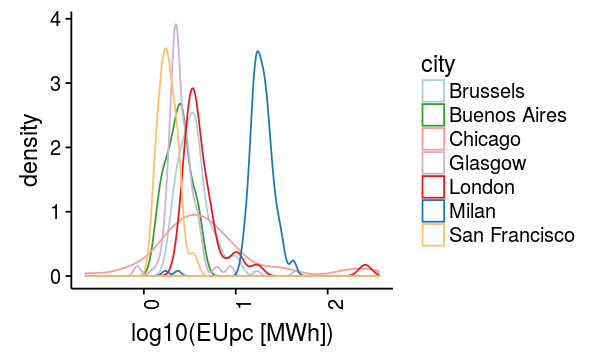

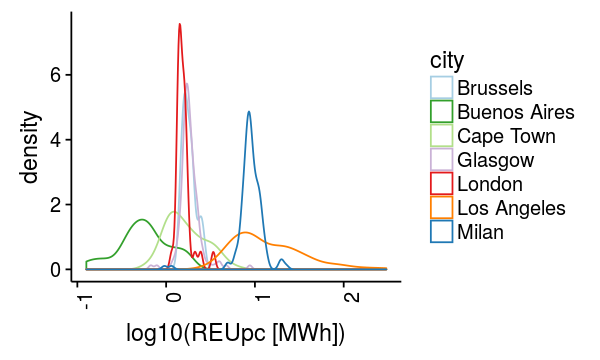

In [14]:
#############################
###### distributions ########
#############################
options(repr.plot.width=5, repr.plot.height=3)

#ggplot(cisbat)+geom_density(aes(population, group=city, color=city))+ 
#theme(axis.text.x = element_text(angle = 90, hjust = 1))+ colScale +xlab("Population")

#ggplot(cisbat)+geom_density(aes(density, group=city, color=city))+ 
#theme(axis.text.x = element_text(angle = 90, hjust = 1))+ colScale +xlab("Population Density")

#ggplot(cisbat)+geom_density(aes(householdIncome_PPP, group=city, color=city))+ 
#theme(axis.text.x = element_text(angle = 90, hjust = 1))+ colScale +xlab("Income [PPP]")

#ggplot(cisbat)+geom_density(aes(naturalGasUse_percapita_mwh, group=city, color=city))+ 
#theme(axis.text.x = element_text(angle = 90, hjust = 1))+ colScale +xlab("NGCpc [MWh]")

#ggplot(cisbat)+geom_density(aes(electricityUse_percapita_mwh, group=city, color=city))+ 
#theme(axis.text.x = element_text(angle = 90, hjust = 1))+ colScale +xlab("ECpc [MWh]")

#ggplot(cisbat)+geom_density(aes(residencialElectricityUse_percapita_mwh, group=city, color=city))+ 
#theme(axis.text.x = element_text(angle = 90, hjust = 1))+ colScale +xlab("RECpc [MWh]")




ggplot(cisbat)+geom_density(aes(log10(population), group=city, color=city))+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))+ colScale +xlab("log10(Population)")

ggplot(cisbat)+geom_density(aes(log10(density), group=city, color=city))+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))+ colScale +xlab("log10(Population Density)")

ggplot(cisbat)+geom_density(aes(log10(householdIncome_PPP), group=city, color=city))+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))+ colScale +xlab("log10(Income [PPP])")

ggplot(cisbat)+geom_density(aes(log10(naturalGasUse_percapita_mwh), group=city, color=city))+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))+ colScale +xlab("log10(NGUpc [MWh])")

ggplot(cisbat)+geom_density(aes(log10(electricityUse_percapita_mwh), group=city, color=city))+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))+ colScale +xlab("log10(EUpc [MWh])")

ggplot(cisbat)+geom_density(aes(log10(residencialElectricityUse_percapita_mwh), group=city, color=city))+ 
theme(axis.text.x = element_text(angle = 90, hjust = 1))+ colScale +xlab("log10(REUpc [MWh])")


,EU,REU,NGU,pop,density,income,NGUpc,EUpc,REUpc
EU,1.00,0.83,0.87,0.80,0.22,0.76,0.21,0.30,-0.08
REU,0.83,1.00,0.98,0.99,0.19,0.74,-0.05,0.01,-0.17
NGU,0.87,0.98,1.00,0.96,0.18,0.76,0.02,0.07,-0.16
pop,0.80,0.99,0.96,1.00,0.19,0.70,-0.07,-0.01,-0.21
density,0.22,0.19,0.18,0.19,1.00,0.24,-0.14,-0.04,-0.18
income,0.76,0.74,0.76,0.70,0.24,1.00,0.28,0.34,-0.08
NGUpc,0.21,-0.05,0.02,-0.07,-0.14,0.28,1.00,0.83,0.46
EUpc,0.30,0.01,0.07,-0.01,-0.04,0.34,0.83,1.00,0.26
REUpc,-0.08,-0.17,-0.16,-0.21,-0.18,-0.08,0.46,0.26,1.00


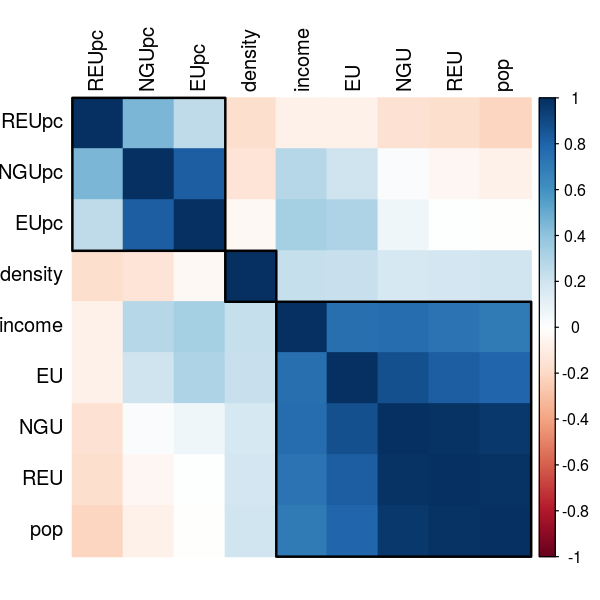

In [15]:
###########################
###### correlation ########
###########################

#log-transform - changes a bit, not fundamentally
#normalize - correlation don't change nothing
#remove outliers
#dimensionality reduction

options(repr.plot.width=5, repr.plot.height=5)

cisbat_data <- cisbat[,-c(1,2,8)]
colnames(cisbat_data) <- c(as.character(names[-c(1,2,8),2]))
#cisbat_data <- scale(cisbat_data)#normalize
#cisbat_data <- log10(cisbat_data)#log


M <- cor(cisbat_data, use="complete.obs", method="pearson") #generates correlation matrix
write.csv(round(M,2), "cor_total.csv")
res1 <- cor.mtest(cisbat_data,0.95)


corrplot(M, method = "color", tl.col="black", order = "hclust", addrect=3) #order by correlational level
#corrplot.mixed(M,  upper = "color", tl.col="black")
#corrplot(M, p.mat = res1[[1]], insig = "blank")
round(M,2)

In [26]:
str(cisbat)

Classes ‘data.table’ and 'data.frame':	796 obs. of  12 variables:
 $ city                                   : atomic  Brussels Brussels Brussels Brussels ...
  ..- attr(*, "levels")= chr  "Brussels" "Milan" "Cape Town" "Buenos Aires" ...
 $ mtu                                    : chr  "Anderlecht" "Auderghem" "Berchem-Sainte-Agathe" "Bruxelles" ...
 $ electricityUse_mwh                     : num  414529 115318 72618 1673883 179947 ...
 $ residencialElectricityUse_mwh          : num  193107 61108 40777 441543 88999 ...
 $ naturalGasUse_mwh                      : num  859392 276504 154773 2249191 382527 ...
 $ population                             : num  115178 32560 23690 170407 46427 ...
 $ density                                : num  6507 3618 8169 5227 14976 ...
 $ householdIncome_usd                    : num  22887 35382 29020 24930 27891 ...
 $ householdIncome_PPP                    : num  28672 44326 36355 31232 34941 ...
 $ naturalGasUse_percapita_mwh            : num  7.46 8.

## Aggregation levels

In [452]:
options(repr.plot.width=4, repr.plot.height=4)


In [528]:
#city

options(repr.plot.width=10, repr.plot.height=10)


city_eu_population <- ggplot(cisbat_city, aes(log(population), log(electricityUse_mwh))) + 
#geom_abline(slope=1, intercept=1.23, linetype = "dashed",colour="gray")+
geom_smooth(method="lm", se= FALSE, colour="black")+
geom_point(size=2.5)+
colScale +ylab("Log[ EU ]")+xlab("Log[ Population ]")+
theme(legend.position="none")


city_reu_population <- ggplot(cisbat_city, aes(log(population), log(residencialElectricityUse_mwh))) + 
#geom_abline(slope=1, intercept=1.1, linetype = "dashed",colour="gray")+
geom_smooth(method="lm", se= FALSE, colour="black")+
geom_point(size=2.5)+
colScale +ylab("Log[ REU ]")+xlab("Log[ Population ]")+
theme(legend.position="none")


city_ngu_population <- ggplot(cisbat_city, aes(log(population), log(naturalGasUse_mwh))) + 
#geom_abline(slope=1, intercept=2, linetype = "dashed",colour="gray")+
geom_smooth(method="lm", se= FALSE, colour="black")+
geom_point(size=2.5)+
colScale +ylab("Log[ NGU ]")+xlab("Log[ Population ]")+
theme(legend.position="none")




city_eu_density <- ggplot(cisbat_city, aes(log(density), log(electricityUse_mwh))) + 
#geom_abline(slope=-1, intercept=25.3, linetype = "dashed",colour="gray")+
geom_smooth(method="lm", se= FALSE, colour="black")+
geom_point(size=2.5)+
colScale +ylab("Log[ EU ]")+xlab("Log[ Density ]")+
theme(legend.position="none")


city_reu_density <- ggplot(cisbat_city, aes(log(density), log(residencialElectricityUse_mwh))) + 
#geom_abline(slope=-1, intercept=24.6, linetype = "dashed",colour="gray")+
geom_smooth(method="lm", se= FALSE, colour="black")+
geom_point(size=2.5)+ 
colScale +ylab("Log[ REU ]")+xlab("Log[ Density ]")+
theme(legend.position="none")


city_ngu_density <- ggplot(cisbat_city, aes(log(density), log(naturalGasUse_mwh))) + 
#geom_abline(slope=1, intercept=7.5, linetype = "dashed",colour="gray")+
geom_smooth(method="lm", se= FALSE, colour="black")+
geom_point(size=2.5)+ 
colScale +ylab("Log[ NGU ]")+xlab("Log[ Density ]")+
theme(legend.position="none")




city_eu_income <- ggplot(cisbat_city, aes(log(householdIncome_PPP), log(electricityUse_mwh))) + 
#geom_abline(slope=1, intercept=5.85, linetype = "dashed",colour="gray")+
geom_smooth(method="lm", se= FALSE, colour="black")+
geom_point(size=2.5)+
colScale +ylab("Log[ EU ]")+xlab("Log[ Income ]")+
theme(legend.position="none")


city_reu_income <- ggplot(cisbat_city, aes(log(householdIncome_PPP), log(residencialElectricityUse_mwh))) + 
#geom_abline(slope=1, intercept=4.9, linetype = "dashed",colour="gray")+
geom_smooth(method="lm", se= FALSE, colour="black")+
geom_point(size=2.5)+ 
colScale +ylab("Log[ REU ]")+xlab("Log[ Income ]")+
theme(legend.position="none")


city_ngu_income <- ggplot(cisbat_city, aes(log(householdIncome_PPP), log(naturalGasUse_mwh))) + 
#geom_abline(slope=1, intercept=5.74, linetype = "dashed",colour="gray")+
geom_smooth(method="lm", se= FALSE, colour="black")+
geom_point(size=2.5)+ 
colScale +ylab("Log[ NGU ]")+xlab("Log[ Income ]")+
theme(legend.position="none")


In [529]:
# MTU - aggregate


#population

mtuag_eu_population <- ggplot(cisbat, aes(log(population), log(electricityUse_mwh), alpha=0.5)) + geom_point()+
geom_smooth(method="lm", se= FALSE, colour="black")+
colScale +ylab("Log[ EU ])")+xlab("Log[ Population ]")+
theme(legend.position="none")

mtuag_reu_population <- ggplot(cisbat, aes(log(population), log(residencialElectricityUse_mwh), alpha=0.5)) + geom_point()+ 
geom_smooth(method="lm", se= FALSE, colour="black")+
colScale +ylab("Log[ REU ]")+xlab("Log[ Population ]")+
theme(legend.position="none")

mtuag_ngu_population <- ggplot(cisbat, aes(log(population), log(naturalGasUse_mwh), alpha=0.5)) + geom_point()+ 
geom_smooth(method="lm", se= FALSE, colour="black")+
colScale +ylab("Log[ NGU ]")+xlab("Log[ Population ]")+
theme(legend.position="none")



# density


mtuag_eu_density <- ggplot(cisbat, aes(log(density), log(electricityUse_mwh), alpha=0.5)) + geom_point()+
geom_smooth(method="lm", se= FALSE, colour="black")+
colScale +ylab("Log[ EU ]")+xlab("Log[ Density ]")+
theme(legend.position="none")

mtuag_reu_density <- ggplot(cisbat, aes(log(density), log(residencialElectricityUse_mwh), alpha=0.5)) + geom_point()+ 
geom_smooth(method="lm", se= FALSE, colour="black")+
colScale +ylab("Log[ REU ]")+xlab("Log[ Density ]")+
theme(legend.position="none")

mtuag_ngu_density <- ggplot(cisbat, aes(log(density), log(naturalGasUse_mwh), alpha=0.5)) + geom_point()+ 
geom_smooth(method="lm", se= FALSE, colour="black")+
colScale +ylab("Log[ NGU ]")+xlab("Log[ Density ]")+
theme(legend.position="none")





# householdIncome_PPP


mtuag_eu_income <- ggplot(cisbat, aes(log(householdIncome_PPP), log(electricityUse_mwh), alpha=0.5)) + geom_point()+
geom_smooth(method="lm", se= FALSE, colour="black")+
colScale +ylab("Log[ EU ]")+xlab("Log[ Income ]")+
theme(legend.position="none")

mtuag_reu_income <- ggplot(cisbat, aes(log(householdIncome_PPP), log(residencialElectricityUse_mwh), alpha=0.5)) + geom_point()+ 
geom_smooth(method="lm", se= FALSE, colour="black")+
colScale +ylab("Log[ REU ]")+xlab("Log[ Income ]")+
theme(legend.position="none")

mtuag_ngu_income <- ggplot(cisbat, aes(log(householdIncome_PPP), log(naturalGasUse_mwh), alpha=0.5)) + geom_point()+ 
geom_smooth(method="lm", se= FALSE, colour="black")+
colScale +ylab("Log[ NGU ]")+xlab("Log[ Income ]")+
theme(legend.position="none")



In [530]:
# MTU dissagregated

# population

mtudissag_eu_population <- ggplot(cisbat, aes(log(population), log(electricityUse_mwh),colour=city, alpha=0.3)) + geom_point()+
geom_smooth(method="lm", se= FALSE)+
colScale +ylab("Log[ EU ]")+xlab("Log[ Population ]")+
theme(legend.position="none")

mtudissag_reu_population <- ggplot(cisbat, aes(log(population), log(residencialElectricityUse_mwh),colour=city, alpha=0.3)) + geom_point()+ 
geom_smooth(method="lm", se= FALSE)+
colScale +ylab("Log[ REU ]")+xlab("Log[ Population ]")+
theme(legend.position="none")

mtudissag_ngu_population <- ggplot(cisbat, aes(log(population), log(naturalGasUse_mwh),colour=city, alpha=0.3)) + geom_point()+ 
geom_smooth(method="lm", se= FALSE)+
colScale +ylab("Log[ NGU ]")+xlab("Log[ Population ]")+
theme(legend.position="none")




# density

mtudissag_eu_density <- ggplot(cisbat, aes(log(density), log(electricityUse_mwh),colour=city, alpha=0.3)) + geom_point()+
geom_smooth(method="lm", se= FALSE)+
colScale +ylab("Log[ EU ]")+xlab("Log[ Density ]")+
theme(legend.position="none")

mtudissag_reu_density <- ggplot(cisbat, aes(log(density), log(residencialElectricityUse_mwh),colour=city, alpha=0.3)) + geom_point()+ 
geom_smooth(method="lm", se= FALSE)+
colScale +ylab("Log[ REU ]")+xlab("Log[ Density ]")+
theme(legend.position="none")

mtudissag_ngu_density <- ggplot(cisbat, aes(log(density), log(naturalGasUse_mwh),colour=city, alpha=0.3)) + geom_point()+ 
geom_smooth(method="lm", se= FALSE)+
colScale +ylab("Log [ NGU ]")+xlab("Log[ Density ]")+
theme(legend.position="none")




# householdIncome_PPP


mtudissag_eu_income <- ggplot(cisbat, aes(log(householdIncome_PPP), log(electricityUse_mwh),colour=city, alpha=0.3)) + geom_point()+
geom_smooth(method="lm", se= FALSE)+
colScale +ylab("Log[ EU ]")+xlab("Log[ Income ]")+
theme(legend.position="none")

mtudissag_reu_income <- ggplot(cisbat, aes(log(householdIncome_PPP), log(residencialElectricityUse_mwh),colour=city, alpha=0.3)) + geom_point()+ 
geom_smooth(method="lm", se= FALSE)+
colScale +ylab("Log[ REU ]")+xlab("Log[ Income ]")+
theme(legend.position="none")

mtudissag_ngu_income <- ggplot(cisbat, aes(log(householdIncome_PPP), log(naturalGasUse_mwh),colour=city, alpha=0.3)) + geom_point()+ 
geom_smooth(method="lm", se= FALSE)+
colScale +ylab("Log[ NGU ]")+xlab("Log[ Income ]")+
theme(legend.position="none")

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 371 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 371 rows containing missing values (geom_point).”Warning message:
“Removed 371 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 371 rows containing missing values (geom_point).”Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 371 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 371 rows containing missing values (geom_point).”Warning message:
“Removed 371 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 371 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”Warning

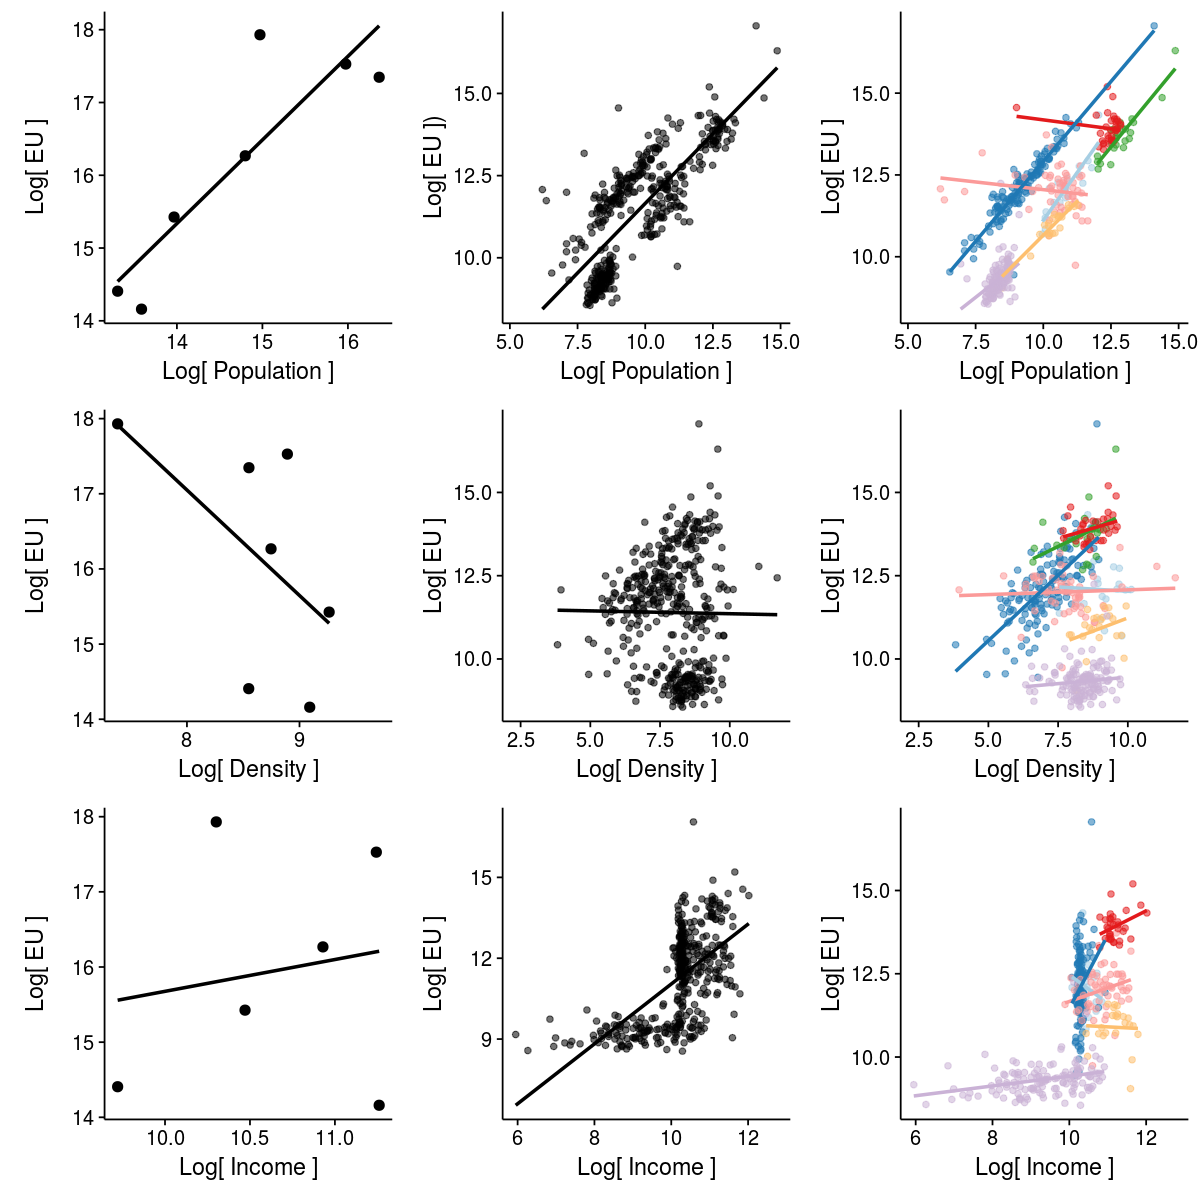

In [531]:

plot_grid(city_eu_population, mtuag_eu_population, mtudissag_eu_population,
          city_eu_density, mtuag_eu_density, mtudissag_eu_density,
          city_eu_income, mtuag_eu_income, mtudissag_eu_income,
          align="hv",
          ncol = 3, nrow = 3)

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 261 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 261 rows containing missing values (geom_point).”Warning message:
“Removed 261 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 261 rows containing missing values (geom_point).”Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 261 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 261 rows containing missing values (geom_point).”Warning message:
“Removed 261 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 261 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”Warning

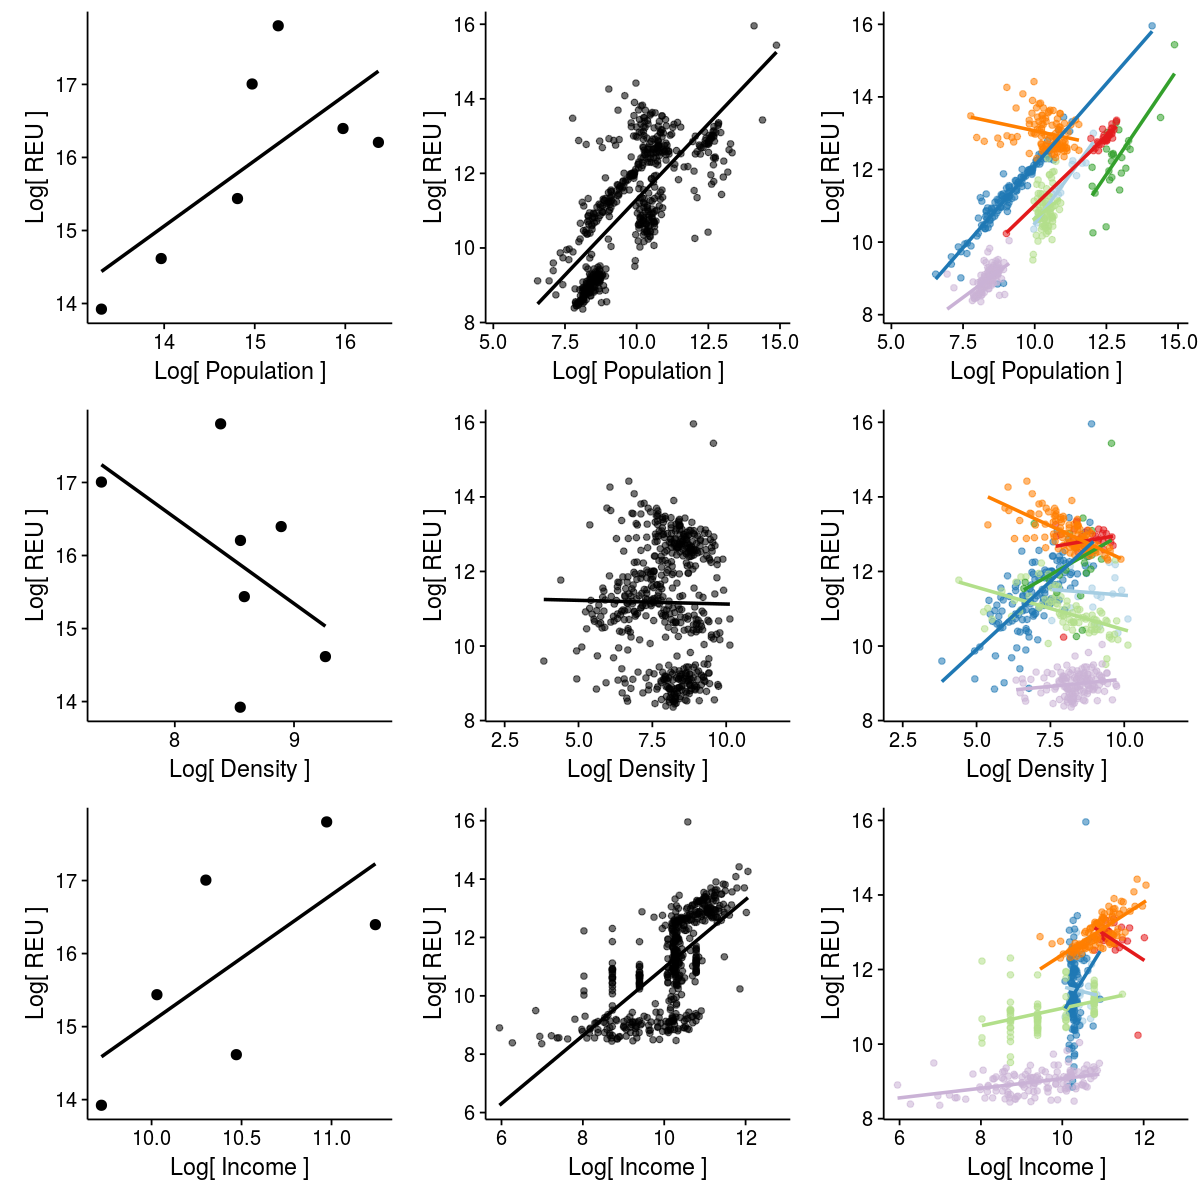

In [532]:

plot_grid(city_reu_population, mtuag_reu_population, mtudissag_reu_population,
          city_reu_density, mtuag_reu_density, mtudissag_reu_density,
          city_reu_income, mtuag_reu_income, mtudissag_reu_income,
          align="hv",
          ncol = 3, nrow = 3)

Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 350 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 350 rows containing missing values (geom_point).”Warning message:
“Removed 350 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 350 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 350 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 350 rows containing missing values (geom_point).”Warning message:
“Removed 350 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 350 rows containing missing values (geom_point).”Warning message:
“Removed 5 rows containing non-finite values (stat_smooth).”Warning

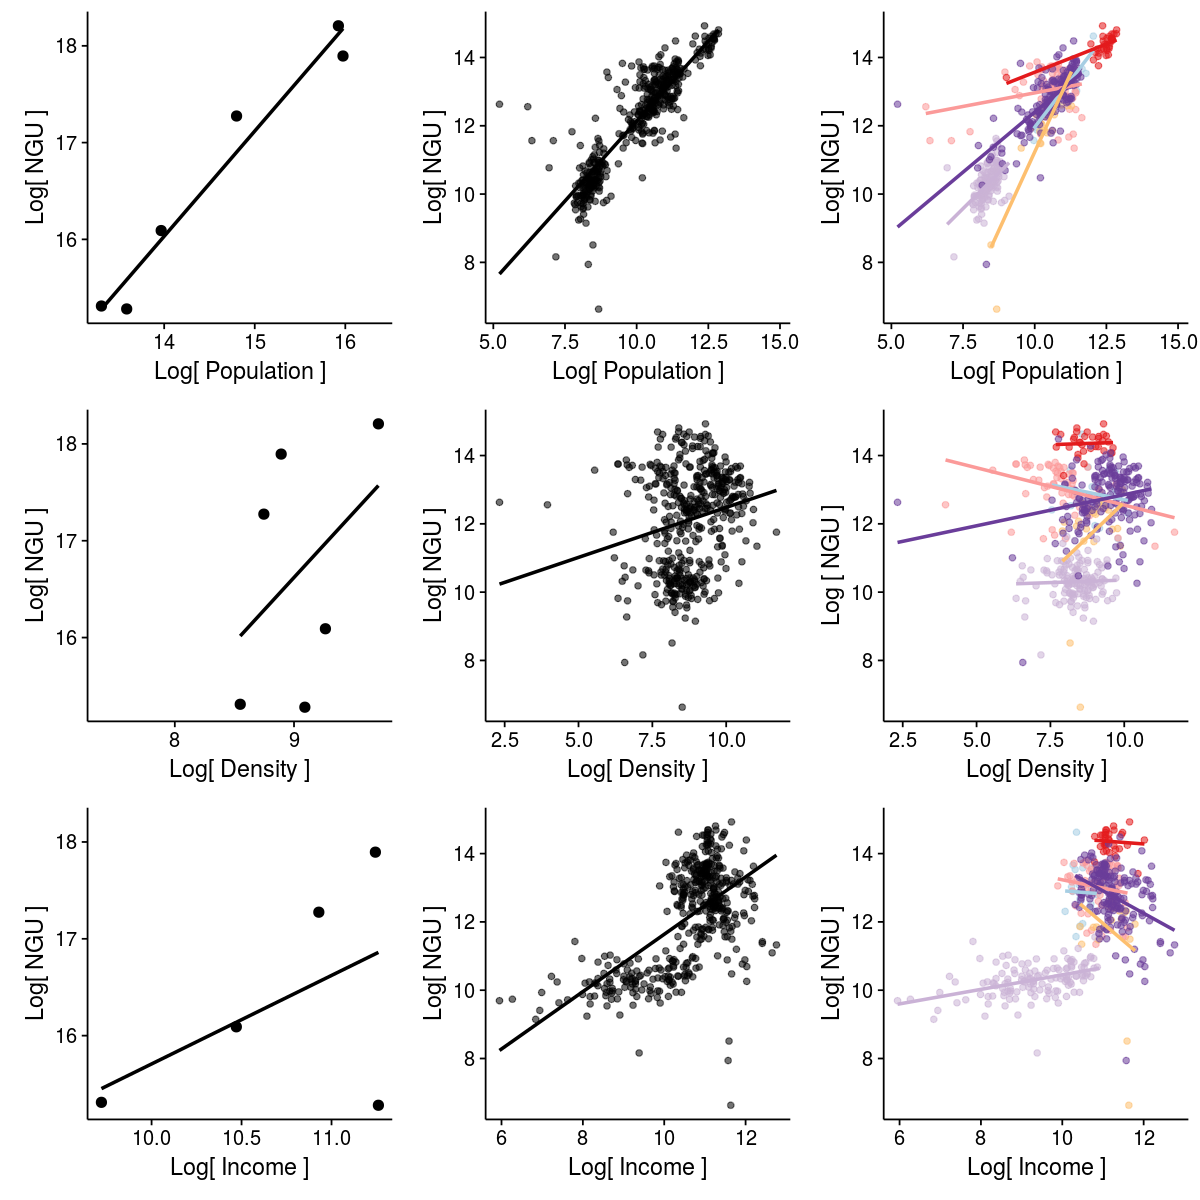

In [533]:

plot_grid(city_ngu_population, mtuag_ngu_population, mtudissag_ngu_population,
          city_ngu_density, mtuag_ngu_density, mtudissag_ngu_density,
          city_ngu_income, mtuag_ngu_income, mtudissag_ngu_income,
          align="hv",
          ncol = 3, nrow = 3)

# REgression

In [ ]:
###################
###### GLM ########
###################

#In instances where both the dependent variable and independent variable(s) are log-transformed variables, 
#the relationship is commonly referred to as elastic in econometrics.
#https://stats.idre.ucla.edu/sas/faq/how-can-i-interpret-log-transformed-variables-in-terms-of-percent-change-in-linear-regression/

In [552]:
regressions <- data.frame(  model= character(0), 
                            city= character(0),  
                            variable= character(0),
                            
                            intercept_estimate= numeric(0),
                            intercept_stderror= numeric(0), 
                            intercept_tvalue= numeric(0),
                          
                            population_estimate= numeric(0), 
                            population_stderror= numeric(0), 
                            population_tvalue= numeric(0),
                          
                            density_estimate= numeric(0),
                            density_stderror= numeric(0), 
                            density_tvalue= numeric(0),
                          
                            income_estimate= numeric(0), 
                            income_stderror= numeric(0), 
                            income_tvalue= numeric(0),
                          
                            
                          
                            r.squared= numeric(0),
                            p.value= numeric(0),
                                  stringsAsFactors=FALSE)

str(regressions)




'data.frame':	0 obs. of  17 variables:
 $ model              : chr 
 $ city               : chr 
 $ variable           : chr 
 $ intercept_estimate : num 
 $ intercept_stderror : num 
 $ intercept_tvalue   : num 
 $ population_estimate: num 
 $ population_stderror: num 
 $ population_tvalue  : num 
 $ density_estimate   : num 
 $ density_stderror   : num 
 $ density_tvalue     : num 
 $ income_estimate    : num 
 $ income_stderror    : num 
 $ income_tvalue      : num 
 $ r.squared          : num 
 $ p.value            : num 


In [553]:
lm_eu_overall <- lm(log(electricityUse_mwh) ~ log(population)+log(density)+log(householdIncome_PPP), na.action=na.exclude, data = cisbat)


lm_reu_overall <- lm(log(residencialElectricityUse_mwh) ~ log(population)+log(density)+log(householdIncome_PPP), na.action=na.exclude, data = cisbat)


lm_ng_overall <- lm(log(naturalGasUse_mwh) ~ log(population)+log(density)+log(householdIncome_PPP), na.action=na.exclude, data = cisbat)


#save html with results
stargazer(lm_eupc_overall, lm_reupc_overall, lm_ngpc_overall, type="html",
 dep.var.labels=c("EU","REU","NGU"),
 covariate.labels=c("Population","Density","Holusehold Income"), out="overall_models.html")




<table style="text-align:center"><tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="3"><em>Dependent variable:</em></td></tr>
<tr><td></td><td colspan="3" style="border-bottom: 1px solid black"></td></tr>
<tr><td style="text-align:left"></td><td>EU</td><td>REU</td><td>NGU</td></tr>
<tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td></tr>
<tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Population</td><td>0.945<sup>***</sup></td><td>0.909<sup>***</sup></td><td>0.908<sup>***</sup></td></tr>
<tr><td style="text-align:left"></td><td>(0.042)</td><td>(0.044)</td><td>(0.027)</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">Density</td><td>-0.546<sup>***</sup></td><td>-0.392<sup>***</sup></td><td>-0.231<sup>***</sup></td></tr>
<tr><td style="text-align:left"></td><td>(0.045)</td><td>(0.044)<

In [555]:
# input regressions parameters to table

# Electricity Use
regressions[1,1] <- "overall_ElectricityUse"
regressions[1,2] <- "Overall"
regressions[1,3] <- "ElectricityUse"

regressions[1,4] <- summary(lm_eu_overall)$coefficients[1,1] #intercept Estimate
regressions[1,5] <- summary(lm_eu_overall)$coefficients[1,2] #intercept std.error
regressions[1,6] <- summary(lm_eu_overall)$coefficients[1,3] #intercept t.avlue

regressions[1,7] <- summary(lm_eu_overall)$coefficients[2,1] #pop Estimate
regressions[1,8] <- summary(lm_eu_overall)$coefficients[2,2] #pop std.error
regressions[1,9] <- summary(lm_eu_overall)$coefficients[2,3] #pop t.avlue

regressions[1,10] <- summary(lm_eu_overall)$coefficients[3,1] #density Estimate
regressions[1,11] <- summary(lm_eu_overall)$coefficients[3,2] #density std.error
regressions[1,12] <- summary(lm_eu_overall)$coefficients[3,3] #density t.avlue

regressions[1,13] <- summary(lm_eu_overall)$coefficients[4,1] #income Estimate
regressions[1,14] <- summary(lm_eu_overall)$coefficients[4,2] #income std.error
regressions[1,15] <- summary(lm_eu_overall)$coefficients[4,3] #income t.avlue

regressions[1,16] <- summary(lm_eu_overall)$r.squared
regressions[1,17] <- anova(lm_eu_overall)$'Pr(>F)'[1]





# Residential Electricity Use
regressions[2,1] <- "overall_ResidentialElectricityUse"
regressions[2,2] <- "Overall"
regressions[2,3] <- "ResidentialElectricityUse"

regressions[2,4] <- summary(lm_reu_overall)$coefficients[1,1] #intercept Estimate
regressions[2,5] <- summary(lm_reu_overall)$coefficients[1,2] #intercept std.error
regressions[2,6] <- summary(lm_reu_overall)$coefficients[1,3] #intercept t.avlue

regressions[2,7] <- summary(lm_reu_overall)$coefficients[2,1] #pop Estimate
regressions[2,8] <- summary(lm_reu_overall)$coefficients[2,2] #pop std.error
regressions[2,9] <- summary(lm_reu_overall)$coefficients[2,3] #pop t.avlue

regressions[2,10] <- summary(lm_reu_overall)$coefficients[3,1] #density Estimate
regressions[2,11] <- summary(lm_reu_overall)$coefficients[3,2] #density std.error
regressions[2,12] <- summary(lm_reu_overall)$coefficients[3,3] #density t.avlue

regressions[2,13] <- summary(lm_reu_overall)$coefficients[4,1] #income Estimate
regressions[2,14] <- summary(lm_reu_overall)$coefficients[4,2] #income std.error
regressions[2,15] <- summary(lm_reu_overall)$coefficients[4,3] #income t.avlue

regressions[2,16] <- summary(lm_reu_overall)$r.squared
regressions[2,17] <- anova(lm_reu_overall)$'Pr(>F)'[1]




# Residential Electricity Use
regressions[3,1] <- "overall_NaturalGasUse"
regressions[3,2] <- "Overall"
regressions[3,3] <- "NaturalGas"

regressions[3,4] <- summary(lm_ng_overall)$coefficients[1,1] #intercept Estimate
regressions[3,5] <- summary(lm_ng_overall)$coefficients[1,2] #intercept std.error
regressions[3,6] <- summary(lm_ng_overall)$coefficients[1,3] #intercept t.avlue

regressions[3,7] <- summary(lm_ng_overall)$coefficients[2,1] #pop Estimate
regressions[3,8] <- summary(lm_ng_overall)$coefficients[2,2] #pop std.error
regressions[3,9] <- summary(lm_ng_overall)$coefficients[2,3] #pop t.avlue

regressions[3,10] <- summary(lm_ng_overall)$coefficients[3,1] #density Estimate
regressions[3,11] <- summary(lm_ng_overall)$coefficients[3,2] #density std.error
regressions[3,12] <- summary(lm_ng_overall)$coefficients[3,3] #density t.avlue

regressions[3,13] <- summary(lm_ng_overall)$coefficients[4,1] #income Estimate
regressions[3,14] <- summary(lm_ng_overall)$coefficients[4,2] #income std.error
regressions[3,15] <- summary(lm_ng_overall)$coefficients[4,3] #income t.avlue

regressions[3,16] <- summary(lm_ng_overall)$r.squared
regressions[3,17] <- anova(lm_ng_overall)$'Pr(>F)'[1]



In [556]:
r <- nrow(regressions)
for (cit in unique(cisbat$city)) {

    r <- r+1 
    cisbat_city <- cisbat[cisbat$city==cit,]
    
    
    city_nospace <- gsub(" ", "", cit, fixed = TRUE)
    model_name <- paste(city_nospace, "_ElectricityUse", sep = "")
    print(model_name)
    
        
    regressions[r,1] <- model_name
    regressions[r,2] <- cit
    regressions[r,3] <- "ElectricityUse"
    
    tryCatch({

        
    # Electricity Use
    lm_eu_city <- lm(log(electricityUse_mwh) ~ log(population)+log(density)+log(householdIncome_PPP), na.action=na.exclude, data = cisbat_city)  
        
        
    regressions[r,4] <- summary(lm_eu_city)$coefficients[1,1] #intercept Estimate
    regressions[r,5] <- summary(lm_eu_city)$coefficients[1,2] #intercept std.error
    regressions[r,6] <- summary(lm_eu_city)$coefficients[1,3] #intercept t.avlue

    regressions[r,7] <- summary(lm_eu_city)$coefficients[2,1] #pop Estimate
    regressions[r,8] <- summary(lm_eu_city)$coefficients[2,2] #pop std.error
    regressions[r,9] <- summary(lm_eu_city)$coefficients[2,3] #pop t.avlue

    regressions[r,10] <- summary(lm_eu_city)$coefficients[3,1] #density Estimate
    regressions[r,11] <- summary(lm_eu_city)$coefficients[3,2] #density std.error
    regressions[r,12] <- summary(lm_eu_city)$coefficients[3,3] #density t.avlue

    regressions[r,13] <- summary(lm_eu_city)$coefficients[4,1] #income Estimate
    regressions[r,14] <- summary(lm_eu_city)$coefficients[4,2] #income std.error
    regressions[r,15] <- summary(lm_eu_city)$coefficients[4,3] #income t.avlue

    regressions[r,16] <- summary(lm_eu_city)$r.squared
    regressions[r,17] <- anova(lm_eu_city)$'Pr(>F)'[1]
 
 }, 
  error=function(e){
    print("### ERRORR ###")
      print(cit)
      })
    
    }

[1] "Brussels_ElectricityUse"
[1] "Milan_ElectricityUse"
[1] "CapeTown_ElectricityUse"
[1] "### ERRORR ###"
[1] "Cape Town"
[1] "BuenosAires_ElectricityUse"
[1] "### ERRORR ###"
[1] "Buenos Aires"
[1] "Chicago_ElectricityUse"
[1] "London_ElectricityUse"
[1] "SanFrancisco_ElectricityUse"
[1] "LosAngeles_ElectricityUse"
[1] "### ERRORR ###"
[1] "Los Angeles"
[1] "Glasgow_ElectricityUse"
[1] "NewYorkCity_ElectricityUse"
[1] "### ERRORR ###"
[1] "New York City"


In [557]:
r <- nrow(regressions)
for (cit in unique(cisbat$city)) {

    r <- r+1 
    cisbat_city <- cisbat[cisbat$city==cit,]
    
    
    city_nospace <- gsub(" ", "", cit, fixed = TRUE)
    model_name <- paste(city_nospace, "_ResidentialElectricityUse", sep = "")
    print(model_name)
    
        
    regressions[r,1] <- model_name
    regressions[r,2] <- cit
    regressions[r,3] <- "ResidentialElectricityUse"
    
    tryCatch({
     
        
    # Residential Electricity Use    
    lm_reu_city <- lm(log(residencialElectricityUse_mwh) ~ log(population)+log(density)+log(householdIncome_PPP), na.action=na.exclude, data = cisbat_city)

    regressions[r,4] <- summary(lm_reu_city)$coefficients[1,1] #intercept Estimate
    regressions[r,5] <- summary(lm_reu_city)$coefficients[1,2] #intercept std.error
    regressions[r,6] <- summary(lm_reu_city)$coefficients[1,3] #intercept t.avlue

    regressions[r,7] <- summary(lm_reu_city)$coefficients[2,1] #pop Estimate
    regressions[r,8] <- summary(lm_reu_city)$coefficients[2,2] #pop std.error
    regressions[r,9] <- summary(lm_reu_city)$coefficients[2,3] #pop t.avlue

    regressions[r,10] <- summary(lm_reu_city)$coefficients[3,1] #density Estimate
    regressions[r,11] <- summary(lm_reu_city)$coefficients[3,2] #density std.error
    regressions[r,12] <- summary(lm_reu_city)$coefficients[3,3] #density t.avlue

    regressions[r,13] <- summary(lm_reu_city)$coefficients[4,1] #income Estimate
    regressions[r,14] <- summary(lm_reu_city)$coefficients[4,2] #income std.error
    regressions[r,15] <- summary(lm_reu_city)$coefficients[4,3] #income t.avlue

    regressions[r,16] <- summary(lm_reu_city)$r.squared
    regressions[r,17] <- anova(lm_reu_city)$'Pr(>F)'[1]
        
        

 }, 
  error=function(e){
    print("### ERRORR ###")
      print(cit)
      })
    
    }

[1] "Brussels_ResidentialElectricityUse"
[1] "Milan_ResidentialElectricityUse"
[1] "CapeTown_ResidentialElectricityUse"
[1] "BuenosAires_ResidentialElectricityUse"
[1] "### ERRORR ###"
[1] "Buenos Aires"
[1] "Chicago_ResidentialElectricityUse"
[1] "### ERRORR ###"
[1] "Chicago"
[1] "London_ResidentialElectricityUse"
[1] "SanFrancisco_ResidentialElectricityUse"
[1] "### ERRORR ###"
[1] "San Francisco"
[1] "LosAngeles_ResidentialElectricityUse"
[1] "Glasgow_ResidentialElectricityUse"
[1] "NewYorkCity_ResidentialElectricityUse"
[1] "### ERRORR ###"
[1] "New York City"


In [558]:
r <- nrow(regressions)
for (cit in unique(cisbat$city)) {

    r <- r+1 
    cisbat_city <- cisbat[cisbat$city==cit,]
    
    
    city_nospace <- gsub(" ", "", cit, fixed = TRUE)
    model_name <- paste(city_nospace, "_NaturalGasUse", sep = "")
    print(model_name)
    
        
    regressions[r,1] <- model_name
    regressions[r,2] <- cit
    regressions[r,3] <- "NaturalGas"
    
    tryCatch({
     
               
    # Natural Gas    
    lm_ngu_city <- lm(log(naturalGasUse_mwh) ~ log(population)+log(density)+log(householdIncome_PPP), na.action=na.exclude, data = cisbat_city)

    regressions[r,4] <- summary(lm_ngu_city)$coefficients[1,1] #intercept Estimate
    regressions[r,5] <- summary(lm_ngu_city)$coefficients[1,2] #intercept std.error
    regressions[r,6] <- summary(lm_ngu_city)$coefficients[1,3] #intercept t.avlue

    regressions[r,7] <- summary(lm_ngu_city)$coefficients[2,1] #pop Estimate
    regressions[r,8] <- summary(lm_ngu_city)$coefficients[2,2] #pop std.error
    regressions[r,9] <- summary(lm_ngu_city)$coefficients[2,3] #pop t.avlue

    regressions[r,10] <- summary(lm_ngu_city)$coefficients[3,1] #density Estimate
    regressions[r,11] <- summary(lm_ngu_city)$coefficients[3,2] #density std.error
    regressions[r,12] <- summary(lm_ngu_city)$coefficients[3,3] #density t.avlue

    regressions[r,13] <- summary(lm_ngu_city)$coefficients[4,1] #income Estimate
    regressions[r,14] <- summary(lm_ngu_city)$coefficients[4,2] #income std.error
    regressions[r,15] <- summary(lm_ngu_city)$coefficients[4,3] #income t.avlue

    regressions[r,16] <- summary(lm_ngu_city)$r.squared
    regressions[r,17] <- anova(lm_ngu_city)$'Pr(>F)'[1]    
 }, 
  error=function(e){
    print("### ERRORR ###")
      print(cit)
      })
    
    }

[1] "Brussels_NaturalGasUse"
[1] "Milan_NaturalGasUse"
[1] "### ERRORR ###"
[1] "Milan"
[1] "CapeTown_NaturalGasUse"
[1] "### ERRORR ###"
[1] "Cape Town"
[1] "BuenosAires_NaturalGasUse"
[1] "### ERRORR ###"
[1] "Buenos Aires"
[1] "Chicago_NaturalGasUse"
[1] "London_NaturalGasUse"
[1] "SanFrancisco_NaturalGasUse"
[1] "LosAngeles_NaturalGasUse"
[1] "### ERRORR ###"
[1] "Los Angeles"
[1] "Glasgow_NaturalGasUse"
[1] "NewYorkCity_NaturalGasUse"


Warning message:
“Removed 4 rows containing missing values (position_stack).”Warning message:
“Removed 4 rows containing missing values (position_stack).”Warning message:
“Removed 5 rows containing missing values (position_stack).”Warning message:
“Removed 4 rows containing missing values (position_stack).”Warning message:
“Removed 4 rows containing missing values (position_stack).”Warning message:
“Removed 4 rows containing missing values (position_stack).”Warning message:
“Removed 4 rows containing missing values (position_stack).”Warning message:
“Removed 4 rows containing missing values (position_stack).”Warning message:
“Removed 4 rows containing missing values (position_stack).”

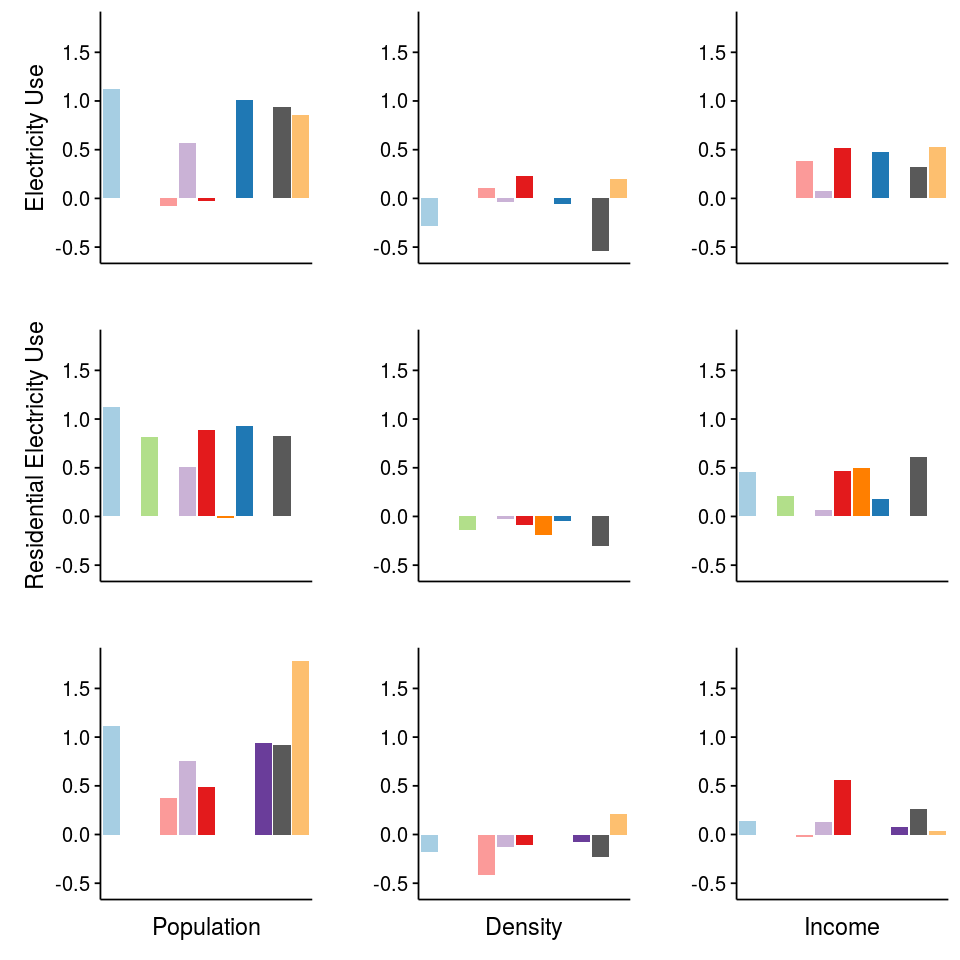

In [568]:
options(repr.plot.width=8, repr.plot.height=8)

eu_population <- ggplot()+
geom_bar(data=regressions[regressions$variable=="ElectricityUse" & regressions$city=="Overall" ,],stat="identity", aes(city, population_estimate))+
geom_bar(data=regressions[regressions$variable=="ElectricityUse" & regressions$city!="Overall" ,],stat="identity", aes(city, population_estimate,fill=city))+
filScale +ylab("Electricity Use")+
ylim(-0.55, 1.8)+
theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),legend.position="none")

eu_density <- ggplot()+
geom_bar(data=regressions[regressions$variable=="ElectricityUse" & regressions$city=="Overall" ,],stat="identity", aes(city, density_estimate))+
geom_bar(data=regressions[regressions$variable=="ElectricityUse" & regressions$city!="Overall" ,],stat="identity", aes(city, density_estimate,fill=city))+
filScale +ylab("")+ 
ylim(-0.55, 1.8)+
theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
         legend.position="none")

eu_income <- ggplot()+
geom_bar(data=regressions[regressions$variable=="ElectricityUse" & regressions$city=="Overall" ,],stat="identity", aes(city, income_estimate))+
geom_bar(data=regressions[regressions$variable=="ElectricityUse" & regressions$city!="Overall" ,],stat="identity", aes(city, income_estimate,fill=city))+
filScale +ylab("")+xlab("Income")+
ylim(-0.55, 1.8)+
theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),legend.position="none")



reu_population <- ggplot()+
geom_bar(data=regressions[regressions$variable=="ResidentialElectricityUse" & regressions$city=="Overall" ,],stat="identity", aes(city, population_estimate))+
geom_bar(data=regressions[regressions$variable=="ResidentialElectricityUse" & regressions$city!="Overall" ,],stat="identity", aes(city, population_estimate,fill=city))+
filScale +ylab("Residential Electricity Use")+
ylim(-0.55, 1.8)+
theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),legend.position="none")

reu_density <- ggplot()+
geom_bar(data=regressions[regressions$variable=="ResidentialElectricityUse" & regressions$city=="Overall" ,],stat="identity", aes(city, density_estimate))+
geom_bar(data=regressions[regressions$variable=="ResidentialElectricityUse" & regressions$city!="Overall" ,],stat="identity", aes(city, density_estimate,fill=city))+
filScale +ylab("")+ 
ylim(-0.55, 1.8)+
theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
         legend.position="none")

reu_income <- ggplot()+
geom_bar(data=regressions[regressions$variable=="ResidentialElectricityUse" & regressions$city=="Overall" ,],stat="identity", aes(city, income_estimate))+
geom_bar(data=regressions[regressions$variable=="ResidentialElectricityUse" & regressions$city!="Overall" ,],stat="identity", aes(city, income_estimate,fill=city))+
filScale +ylab("")+xlab("")+
ylim(-0.55, 1.8)+
theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),legend.position="none")


ngu_population <- ggplot()+
geom_bar(data=regressions[regressions$variable=="NaturalGas" & regressions$city=="Overall" ,],stat="identity", aes(city, population_estimate))+
geom_bar(data=regressions[regressions$variable=="NaturalGas" & regressions$city!="Overall" ,],stat="identity", aes(city, population_estimate,fill=city))+
filScale +ylab("")+xlab("Population")+
ylim(-0.55, 1.8)+
theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),legend.position="none")

ngu_density <- ggplot()+
geom_bar(data=regressions[regressions$variable=="NaturalGas" & regressions$city=="Overall" ,],stat="identity", aes(city, density_estimate))+
geom_bar(data=regressions[regressions$variable=="NaturalGas" & regressions$city!="Overall" ,],stat="identity", aes(city, density_estimate,fill=city))+
filScale +ylab("")+xlab("Density")+
ylim(-0.55, 1.8)+
theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),legend.position="none")


ngu_income <- ggplot()+
geom_bar(data=regressions[regressions$variable=="NaturalGas" & regressions$city=="Overall" ,],stat="identity", aes(city, income_estimate))+
geom_bar(data=regressions[regressions$variable=="NaturalGas" & regressions$city!="Overall" ,],stat="identity", aes(city, income_estimate,fill=city))+
filScale +ylab("")+xlab("Income")+
ylim(-0.55, 1.8)+
theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),legend.position="none")



plot_grid(eu_population, eu_density, eu_income, reu_population, reu_density, reu_income, ngu_population, ngu_density, ngu_income, 
          align="hv",
          ncol = 3, nrow = 3)


## Regression at city level

##### to be done

In [570]:
str(cisbat_city)

Classes ‘data.table’ and 'data.frame':	180 obs. of  12 variables:
 $ city                                   : atomic  New York City New York City New York City New York City ...
  ..- attr(*, "levels")= chr  "Brussels" "Milan" "Cape Town" "Buenos Aires" ...
 $ mtu                                    : chr  "10001" "10002" "10003" "10004" ...
 $ electricityUse_mwh                     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ residencialElectricityUse_mwh          : num  NA NA NA NA NA NA NA NA NA NA ...
 $ naturalGasUse_mwh                      : num  497384 630426 525000 91242 53631 ...
 $ population                             : num  21102 81410 56024 3089 7135 ...
 $ density                                : num  13112 35743 37524 2131 37471 ...
 $ householdIncome_usd                    : num  121403 57063 140822 245827 159876 ...
 $ householdIncome_PPP                    : num  121403 57063 140822 245827 159876 ...
 $ naturalGasUse_percapita_mwh            : num  23.57 7.74 9.37 29.

In [572]:
#lm_eu_city <- lm(log(electricityUse_mwh) ~ log(population)+log(density)+log(householdIncome_PPP), na.action=na.exclude, data = cisbat_city)

#lm_reu_overall <- lm(log(residencialElectricityUse_mwh) ~ log(population)+log(density)+log(householdIncome_usd), na.action=na.exclude, data = cisbat_city)

lm_ng_overall <- lm(log(naturalGasUse_mwh) ~ log(population)+log(density)+log(householdIncome_usd), na.action=na.exclude, data = cisbat_city)



In [573]:
summary(lm_ng_overall)


Call:
lm(formula = log(naturalGasUse_mwh) ~ log(population) + log(density) + 
    log(householdIncome_usd), data = cisbat_city, na.action = na.exclude)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.95821 -0.23625 -0.03397  0.21532  2.07482 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               2.70148    1.46989   1.838   0.0678 .  
log(population)           0.94137    0.06512  14.456   <2e-16 ***
log(density)             -0.07232    0.05170  -1.399   0.1636    
log(householdIncome_usd)  0.07310    0.09627   0.759   0.4487    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.523 on 175 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.6305,	Adjusted R-squared:  0.6242 
F-statistic: 99.55 on 3 and 175 DF,  p-value: < 2.2e-16


# Clustering

## tree

In [343]:
#set-up environment
library(partykit)
library(rpart)
options(repr.plot.width=8, repr.plot.height=8)

### electricityUse_mwh


Regression tree:
rpart(formula = log(electricityUse_mwh) ~ as.factor(city) + log(population) + 
    log(density) + log(householdIncome_PPP), data = cisbat, method = "anova")

Variables actually used in tree construction:
[1] as.factor(city) log(population)

Root node error: 1261.7/425 = 2.9687

n=425 (371 observations deleted due to missingness)

        CP nsplit rel error  xerror     xstd
1 0.659046      0   1.00000 1.00391 0.051398
2 0.122097      1   0.34095 0.36148 0.031845
3 0.044623      2   0.21886 0.24746 0.027985
4 0.037657      3   0.17423 0.21583 0.027613
5 0.015633      4   0.13658 0.16308 0.023438
6 0.013598      5   0.12094 0.16297 0.023662
7 0.010000      6   0.10735 0.13191 0.019075
Call:
rpart(formula = log(electricityUse_mwh) ~ as.factor(city) + log(population) + 
    log(density) + log(householdIncome_PPP), data = cisbat, method = "anova")
  n=425 (371 observations deleted due to missingness)

          CP nsplit rel error    xerror       xstd
1 0.65904595      0 1

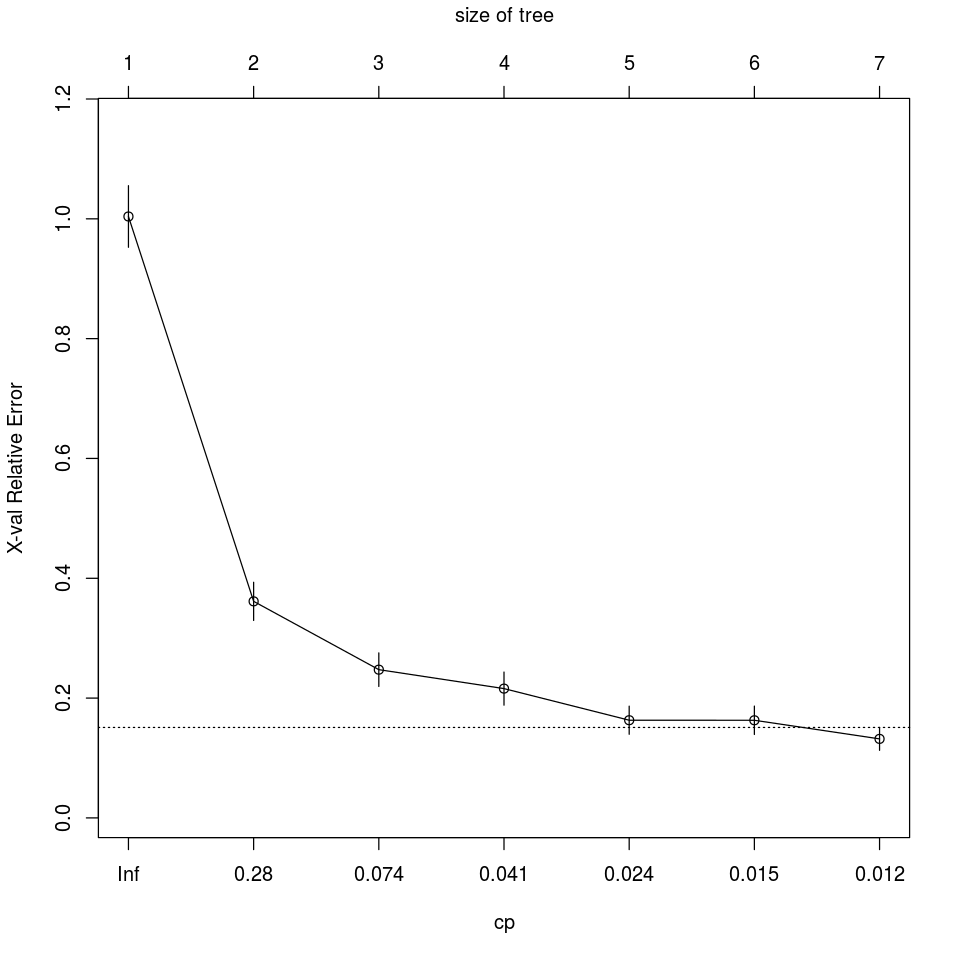

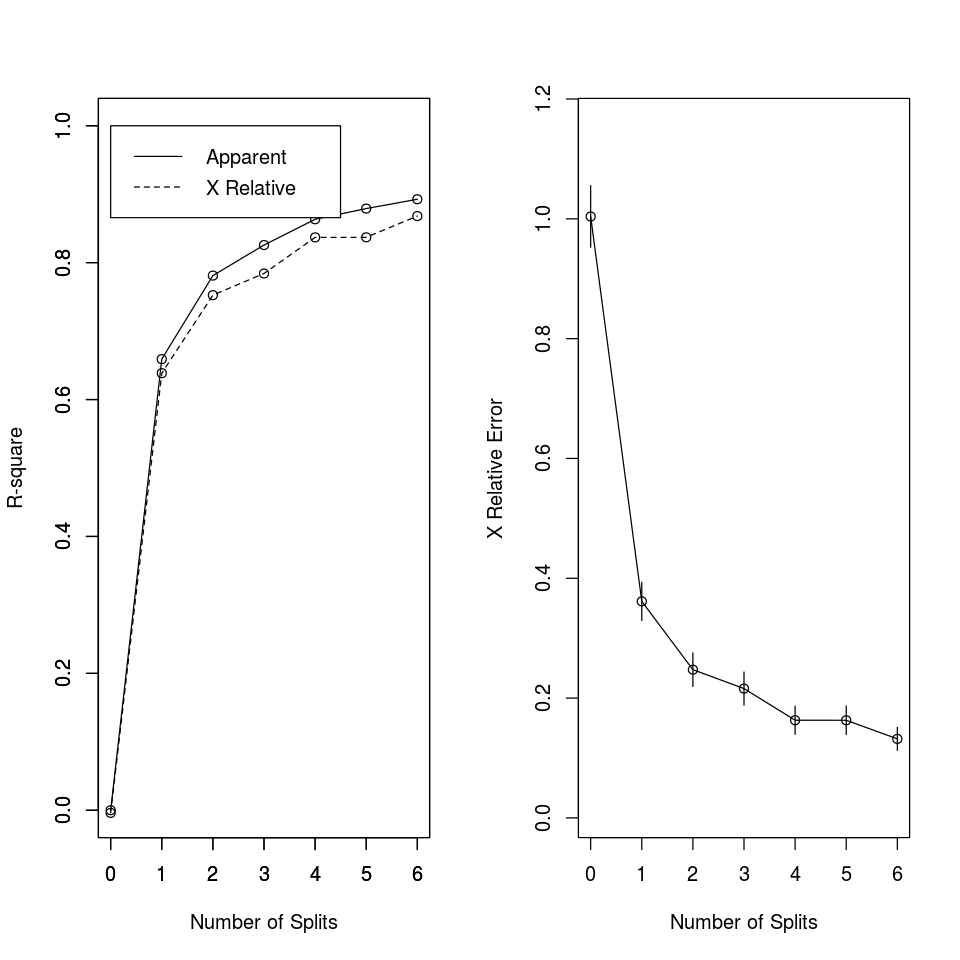

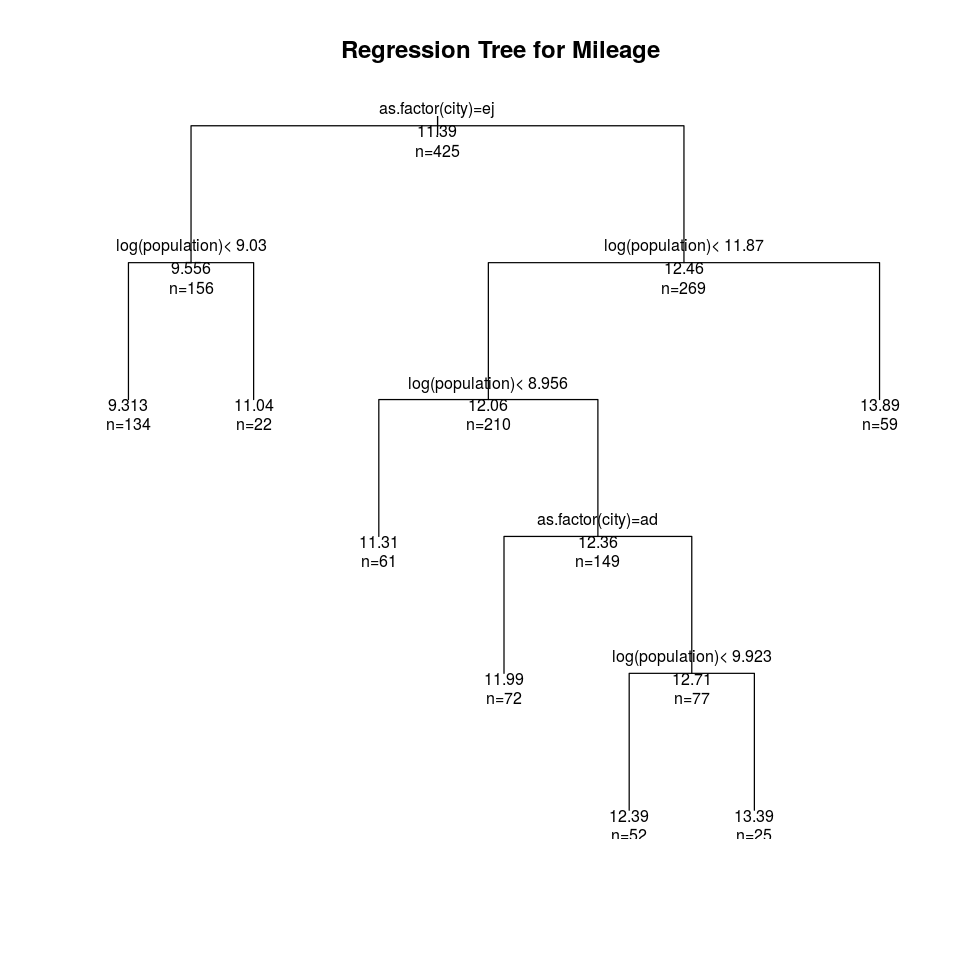

In [345]:
fit <- rpart(log(electricityUse_mwh)~as.factor(city) + log(population) + log(density) + log(householdIncome_PPP), method="anova", data=cisbat)
printcp(fit) # display the results
plotcp(fit)

summary(fit) 

# create additional plots
par(mfrow=c(1,2)) # two plots on one page
rsq.rpart(fit) # visualize cross-validation results  

par(mfrow=c(1,1)) 

# plot tree
plot(fit, uniform=TRUE, main="Regression Tree for Mileage ")
text(fit, use.n=TRUE, all=TRUE, cex=.8)

### residencialElectricityUse_mwh


Regression tree:
rpart(formula = log(residencialElectricityUse_mwh) ~ as.factor(city) + 
    log(population) + log(density) + log(householdIncome_PPP), 
    data = cisbat, method = "anova")

Variables actually used in tree construction:
[1] as.factor(city) log(population)

Root node error: 1359.6/535 = 2.5414

n=535 (261 observations deleted due to missingness)

        CP nsplit rel error  xerror     xstd
1 0.619628      0   1.00000 1.00719 0.042218
2 0.198209      1   0.38037 0.38259 0.025751
3 0.023161      2   0.18216 0.18536 0.022835
4 0.020007      3   0.15900 0.17143 0.020017
5 0.012844      5   0.11899 0.14954 0.019155
6 0.010000      6   0.10614 0.13404 0.018785
Call:
rpart(formula = log(residencialElectricityUse_mwh) ~ as.factor(city) + 
    log(population) + log(density) + log(householdIncome_PPP), 
    data = cisbat, method = "anova")
  n=535 (261 observations deleted due to missingness)

          CP nsplit rel error    xerror       xstd
1 0.61962847      0 1.0000000 1.00

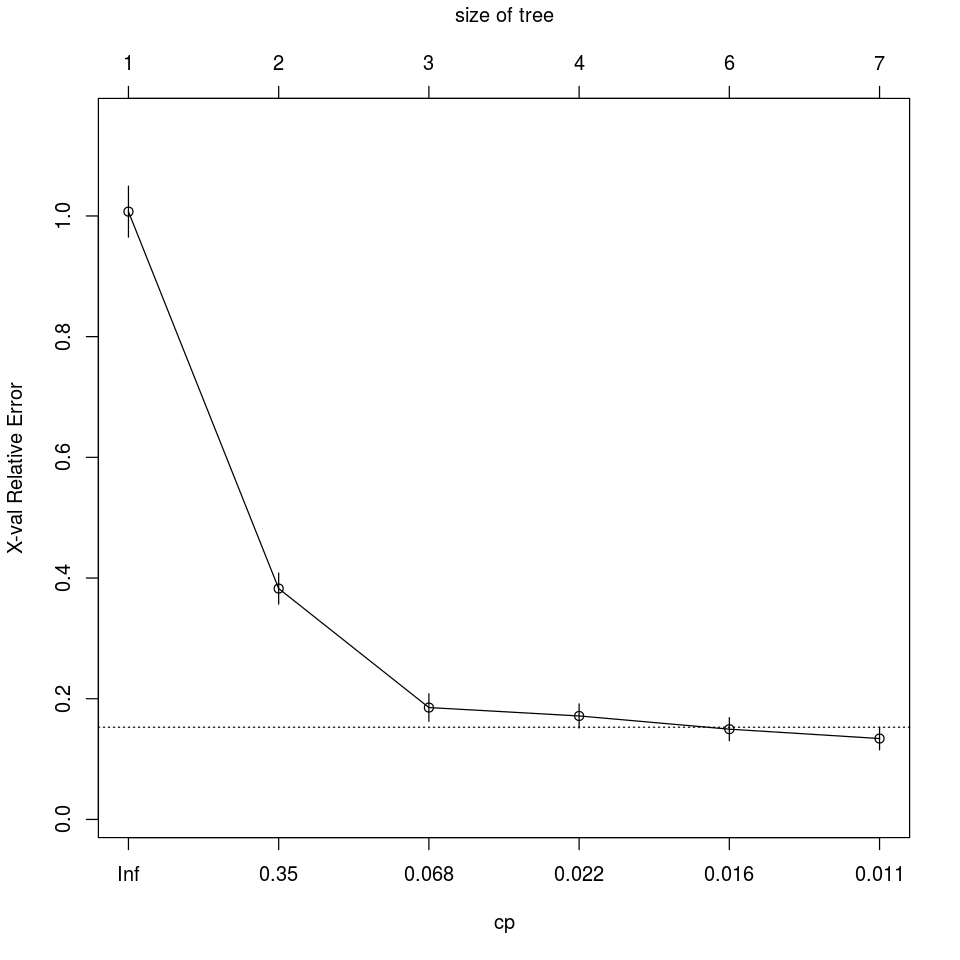

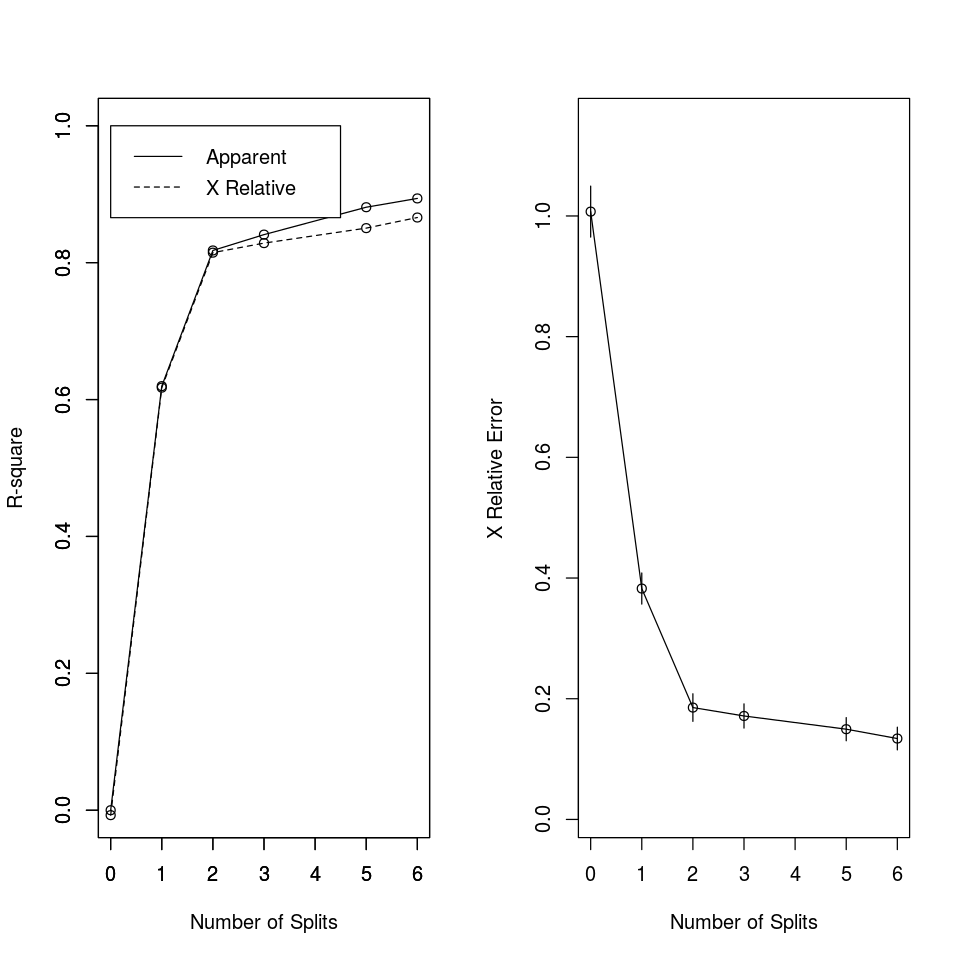

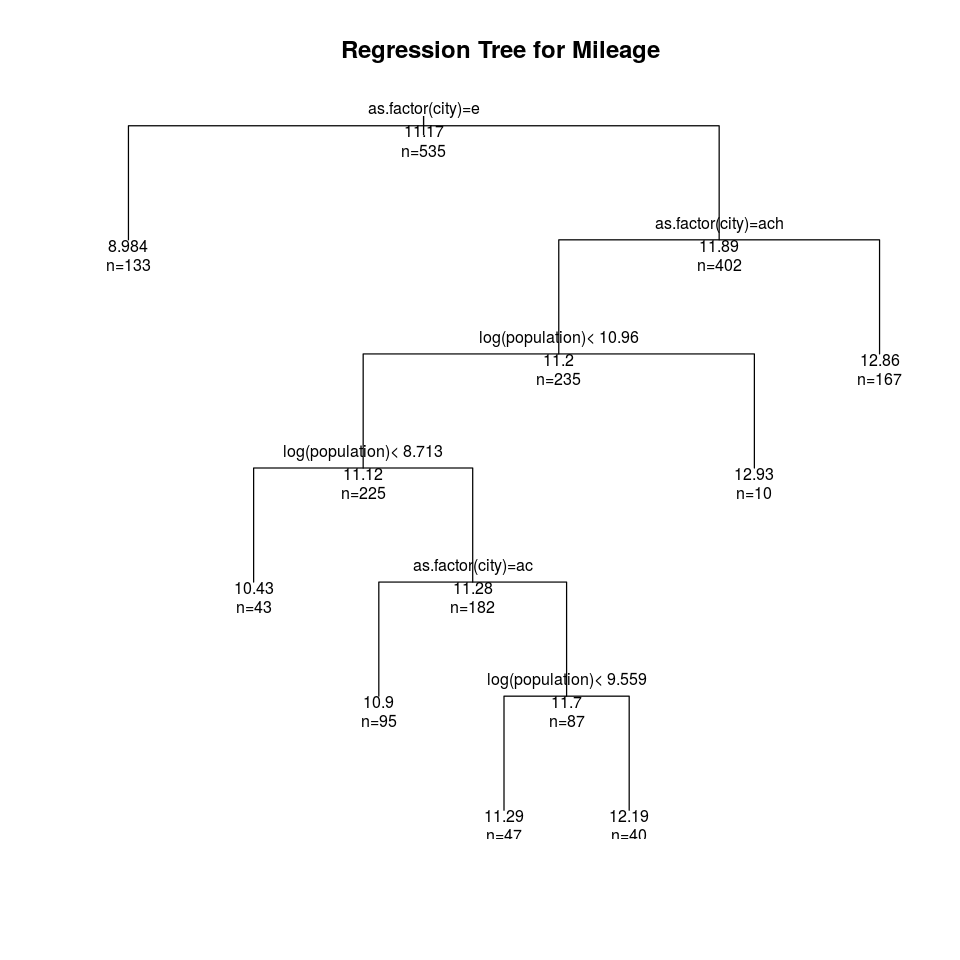

In [348]:
fit <- rpart(log(residencialElectricityUse_mwh)~as.factor(city) + log(population) + log(density) + log(householdIncome_PPP), method="anova", data=cisbat)
printcp(fit) # display the results
plotcp(fit)

summary(fit) 

# create additional plots
par(mfrow=c(1,2)) # two plots on one page
rsq.rpart(fit) # visualize cross-validation results  

par(mfrow=c(1,1)) 

# plot tree
plot(fit, uniform=TRUE, main="Regression Tree for Mileage ")
text(fit, use.n=TRUE, all=TRUE, cex=.8)

### naturalGasUse_mwh


Regression tree:
rpart(formula = log(naturalGasUse_mwh) ~ as.factor(city) + log(population) + 
    log(density) + log(householdIncome_PPP), data = cisbat, method = "anova")

Variables actually used in tree construction:
[1] as.factor(city) log(population)

Root node error: 980.08/446 = 2.1975

n=446 (350 observations deleted due to missingness)

        CP nsplit rel error  xerror     xstd
1 0.711957      0   1.00000 1.00341 0.055107
2 0.071602      1   0.28804 0.31649 0.029666
3 0.030715      2   0.21644 0.25393 0.027645
4 0.013462      3   0.18573 0.22831 0.027023
5 0.010652      4   0.17226 0.20458 0.024401
6 0.010000      5   0.16161 0.20445 0.024402
Call:
rpart(formula = log(naturalGasUse_mwh) ~ as.factor(city) + log(population) + 
    log(density) + log(householdIncome_PPP), data = cisbat, method = "anova")
  n=446 (350 observations deleted due to missingness)

          CP nsplit rel error    xerror       xstd
1 0.71195650      0 1.0000000 1.0034134 0.05510738
2 0.07160199     

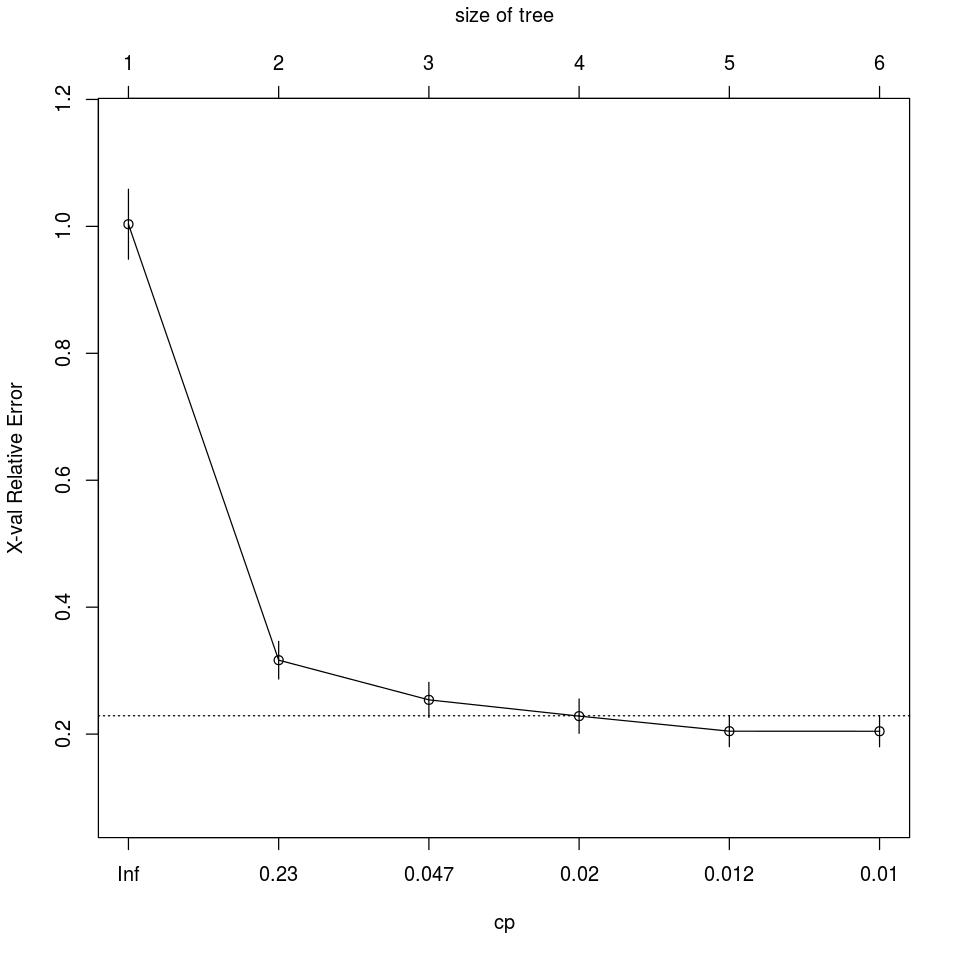

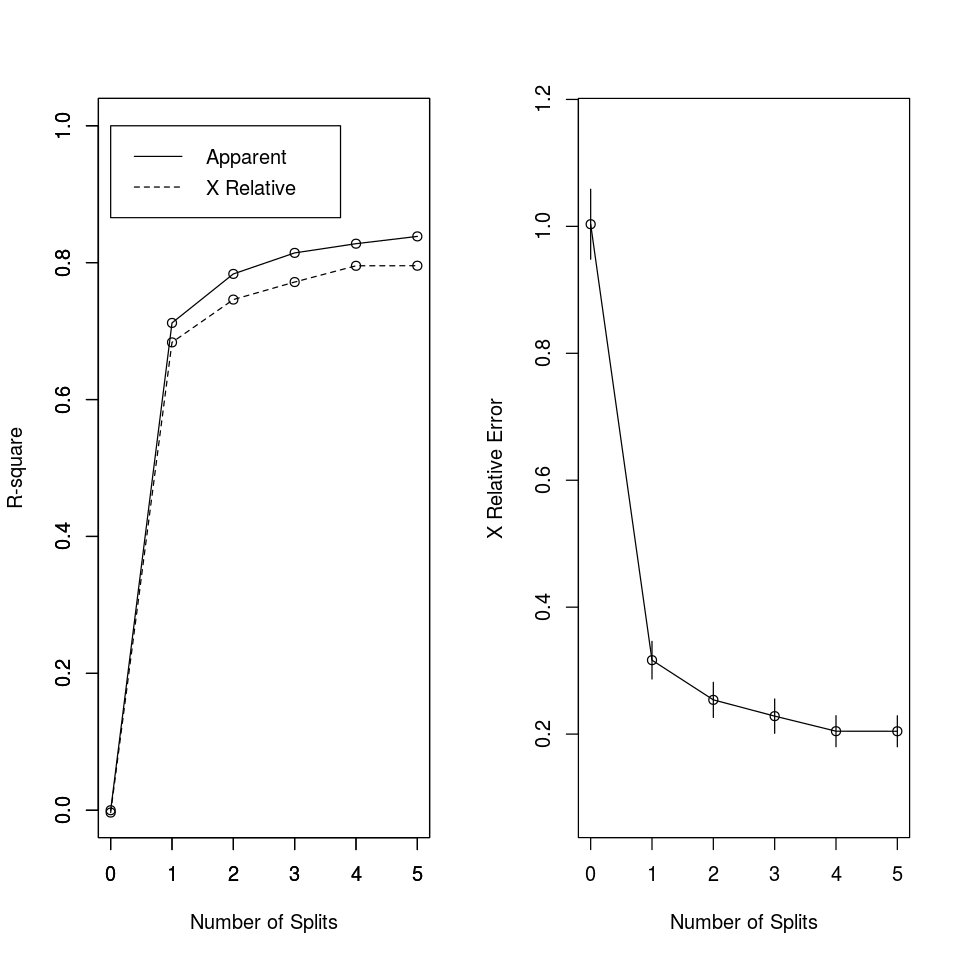

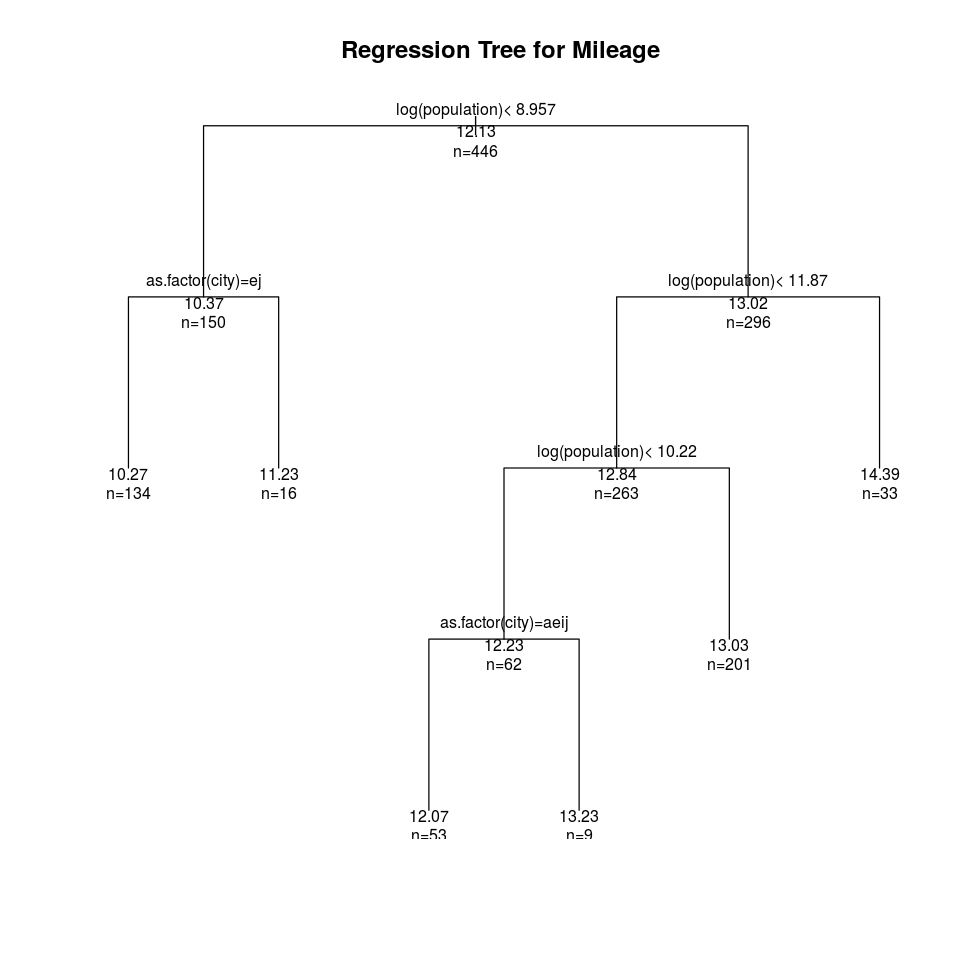

In [347]:
fit <- rpart(log(naturalGasUse_mwh)~as.factor(city) + log(population) + log(density) + log(householdIncome_PPP), method="anova", data=cisbat)
printcp(fit) # display the results
plotcp(fit)

summary(fit) 

# create additional plots
par(mfrow=c(1,2)) # two plots on one page
rsq.rpart(fit) # visualize cross-validation results  

par(mfrow=c(1,1)) 

# plot tree
plot(fit, uniform=TRUE, main="Regression Tree for Mileage ")
text(fit, use.n=TRUE, all=TRUE, cex=.8)

# Annexx

## Marco-Analysis

In [544]:
options(repr.plot.width=4, repr.plot.height=4)

### City-Level

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

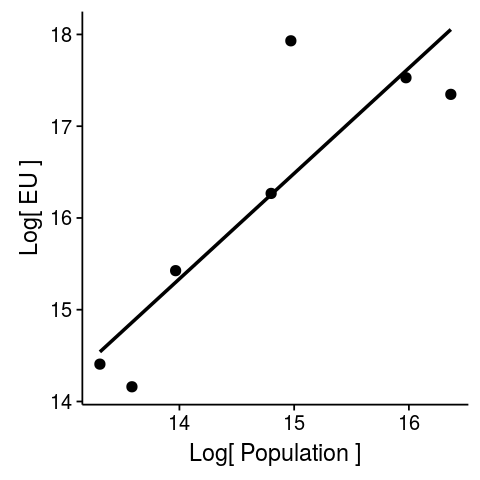

Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 4 rows containing missing values (geom_point).”

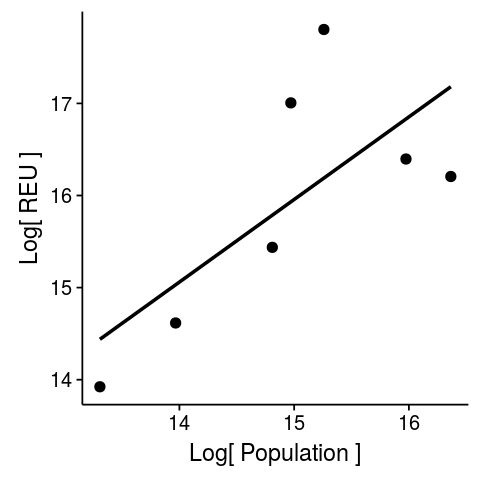

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

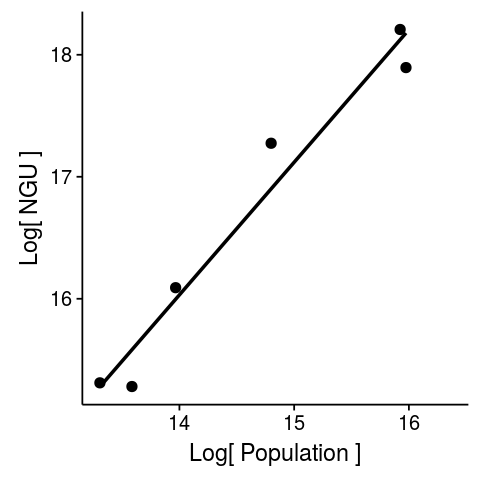

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

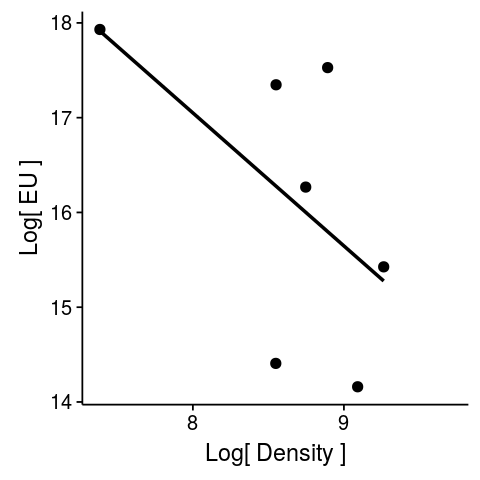

Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 4 rows containing missing values (geom_point).”

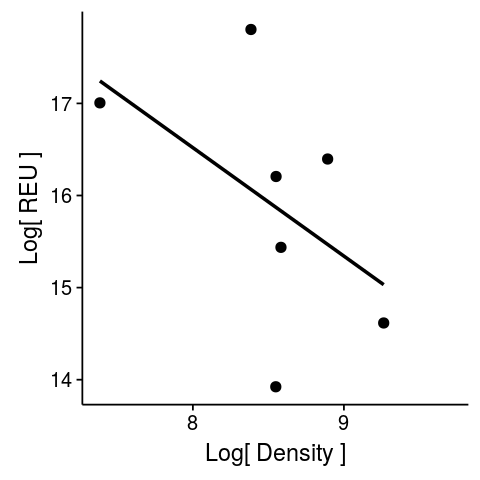

Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 4 rows containing missing values (geom_point).”

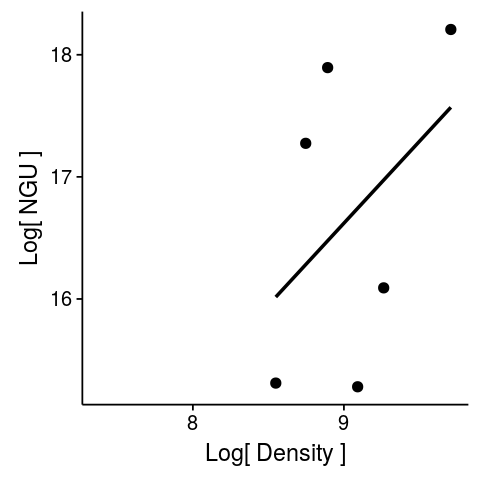

Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 4 rows containing missing values (geom_point).”

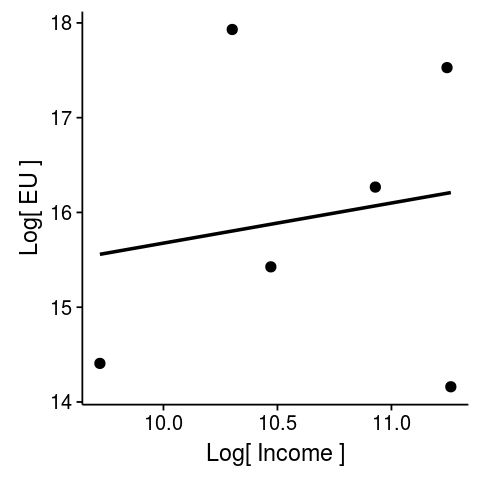

Warning message:
“Removed 5 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 5 rows containing missing values (geom_point).”

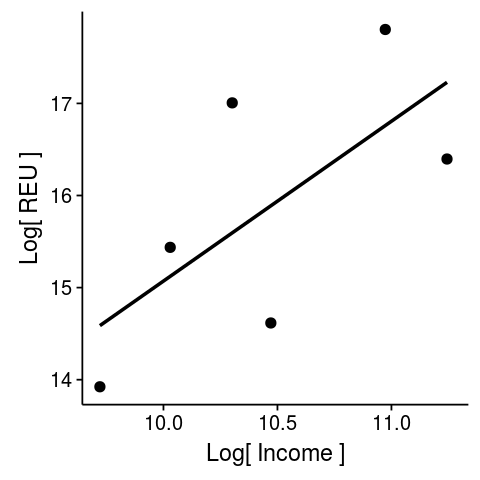

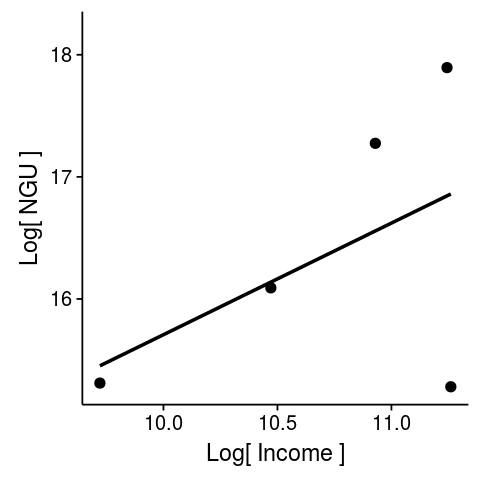

In [545]:
city_eu_population
city_reu_population
city_ngu_population
city_eu_density
city_reu_density
city_ngu_density
city_eu_income
city_reu_income
city_ngu_income


# MTU - aggregate

Warning message:
“Removed 371 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 371 rows containing missing values (geom_point).”

Warning message:
“Removed 261 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 261 rows containing missing values (geom_point).”

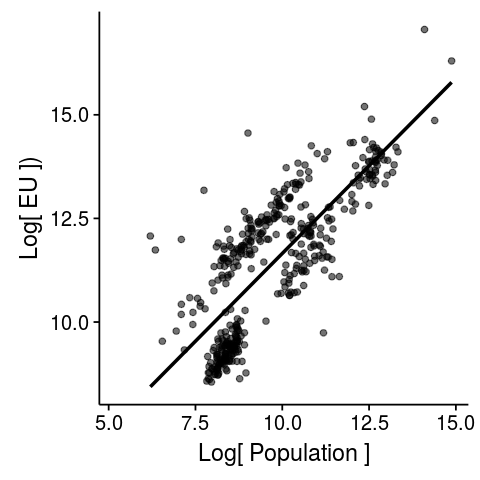

Warning message:
“Removed 350 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 350 rows containing missing values (geom_point).”

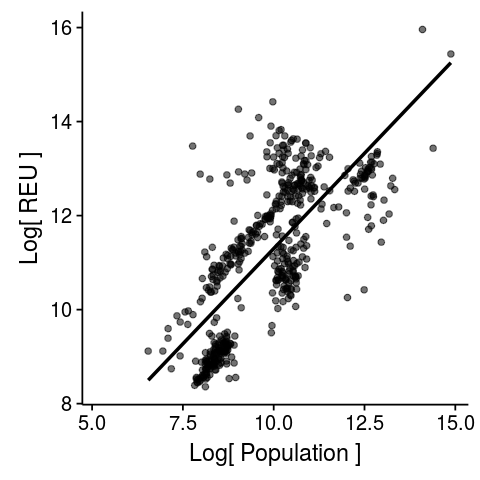

Warning message:
“Removed 371 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 371 rows containing missing values (geom_point).”

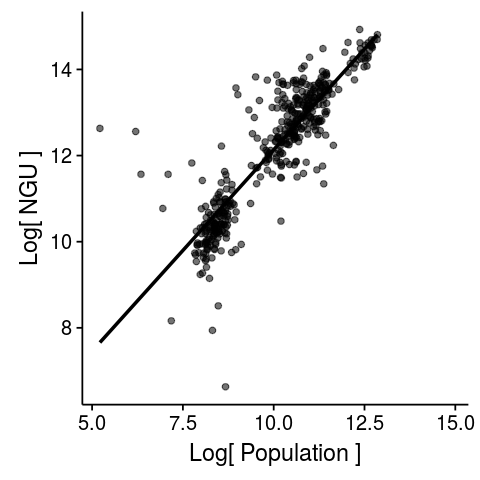

Warning message:
“Removed 261 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 261 rows containing missing values (geom_point).”

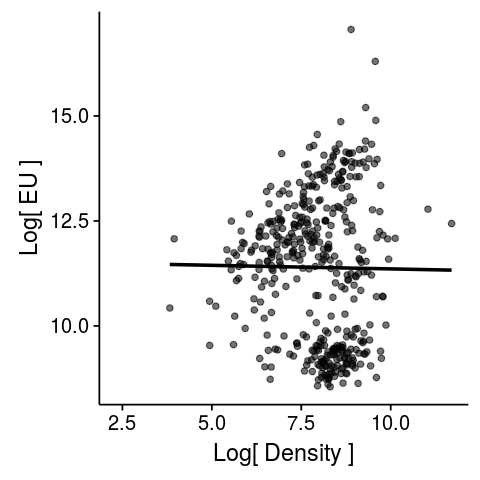

Warning message:
“Removed 350 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 350 rows containing missing values (geom_point).”

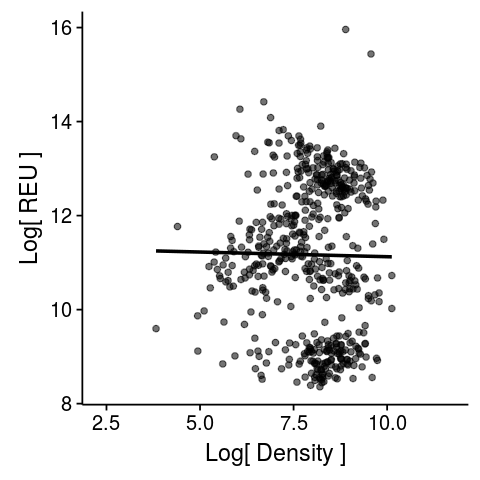

Warning message:
“Removed 396 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 396 rows containing missing values (geom_point).”

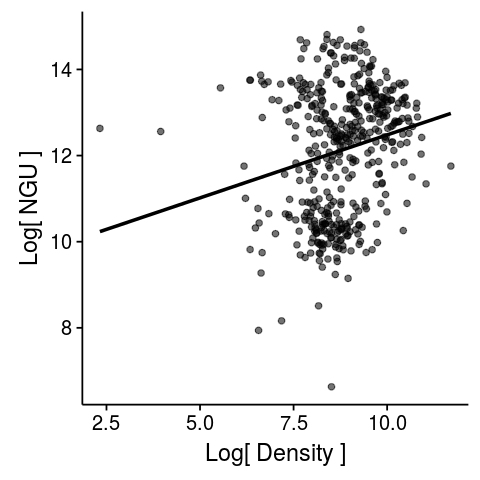

Warning message:
“Removed 286 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 286 rows containing missing values (geom_point).”

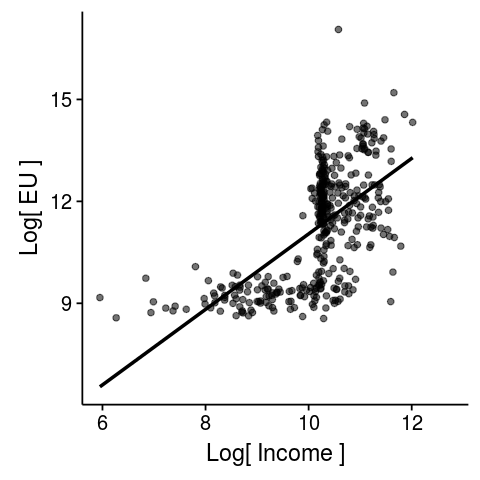

Warning message:
“Removed 351 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 351 rows containing missing values (geom_point).”

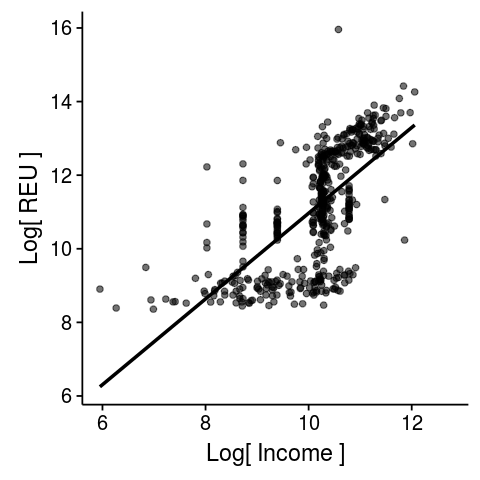

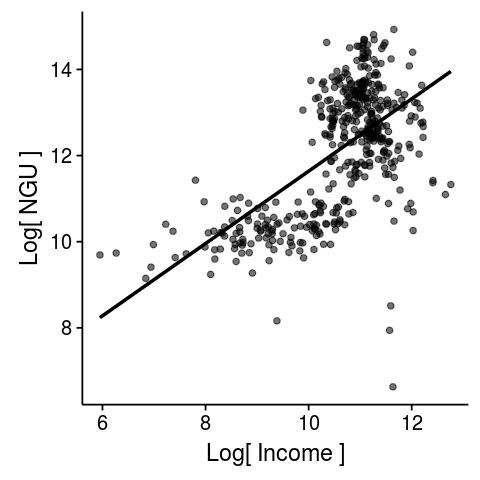

In [546]:
mtuag_eu_population
mtuag_reu_population
mtuag_ngu_population
mtuag_eu_density
mtuag_reu_density
mtuag_ngu_density
mtuag_eu_income
mtuag_reu_income
mtuag_ngu_income


# MTU dissagregated

Warning message:
“Removed 371 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 371 rows containing missing values (geom_point).”

Warning message:
“Removed 261 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 261 rows containing missing values (geom_point).”

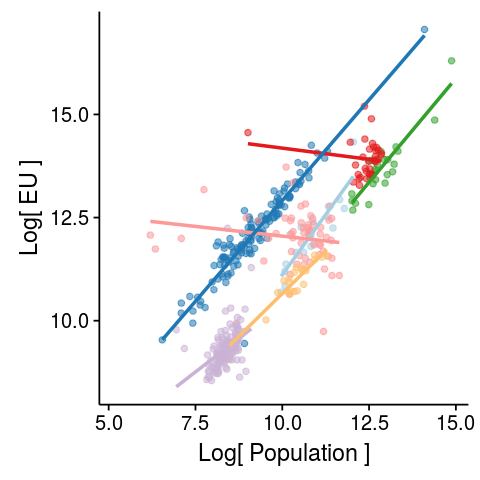

Warning message:
“Removed 350 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 350 rows containing missing values (geom_point).”

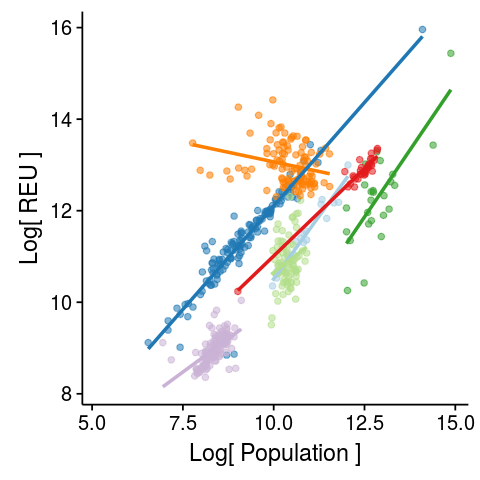

Warning message:
“Removed 371 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 371 rows containing missing values (geom_point).”

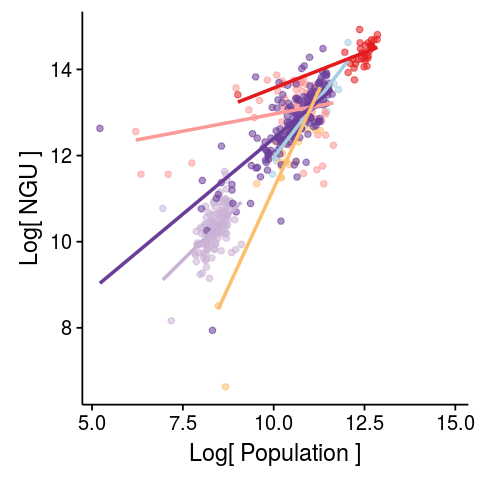

Warning message:
“Removed 261 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 261 rows containing missing values (geom_point).”

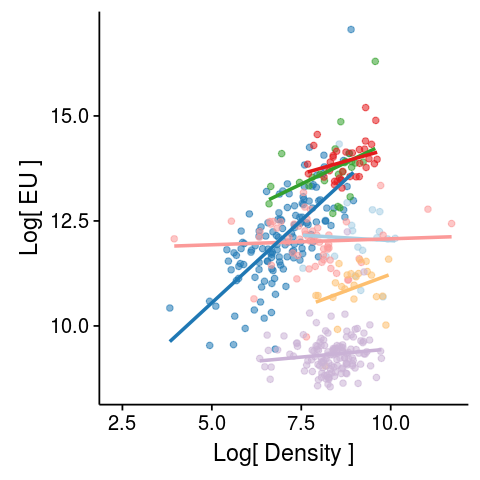

Warning message:
“Removed 350 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 350 rows containing missing values (geom_point).”

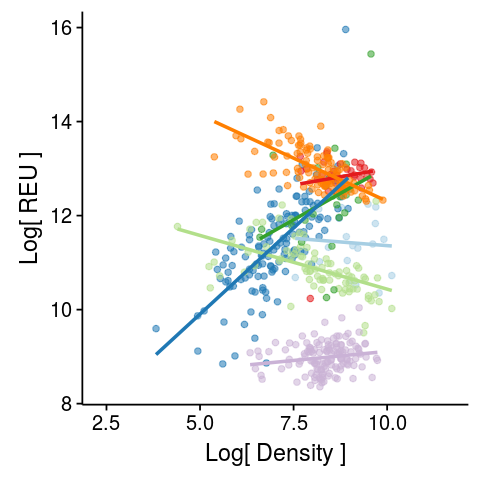

Warning message:
“Removed 396 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 396 rows containing missing values (geom_point).”

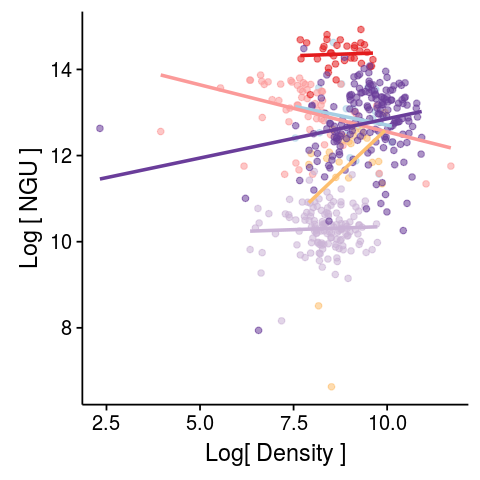

Warning message:
“Removed 286 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 286 rows containing missing values (geom_point).”

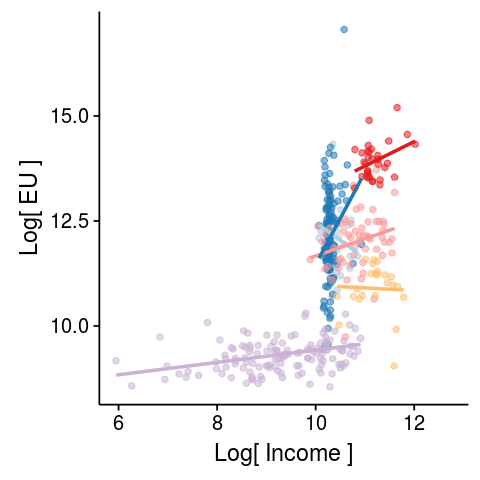

Warning message:
“Removed 351 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 351 rows containing missing values (geom_point).”

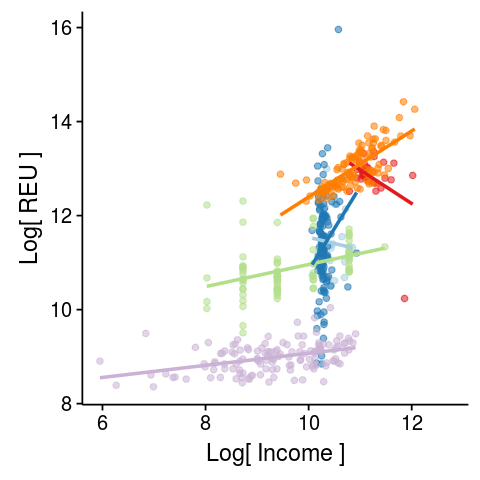

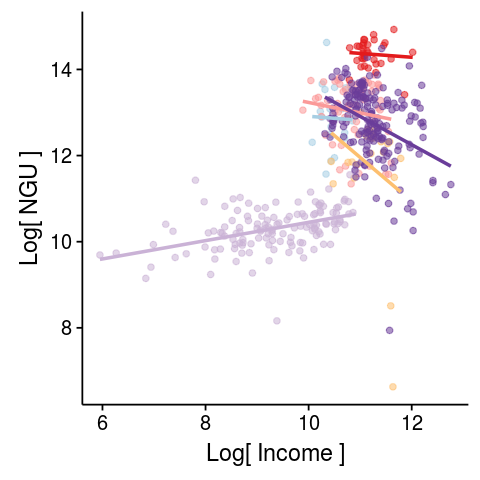

In [547]:
mtudissag_eu_population
mtudissag_reu_population
mtudissag_ngu_population
mtudissag_eu_density
mtudissag_reu_density
mtudissag_ngu_density
mtudissag_eu_income
mtudissag_reu_income
mtudissag_ngu_income

## Regression

### table with regression data

In [569]:
regressions

model,city,variable,intercept_estimate,intercept_stderror,intercept_tvalue,population_estimate,population_stderror,population_tvalue,density_estimate,density_stderror,density_tvalue,income_estimate,income_stderror,income_tvalue,r.squared,p.value
overall_ElectricityUse,Overall,ElectricityUse,3.3413848,0.5918283,5.6458685,0.93359657,0.04144872,22.5241352,-0.540574666,0.04454810,-12.13462830,0.32628031,0.05860743,5.56721771,0.72895008,5.855843e-99
overall_ResidentialElectricityUse,Overall,ResidentialElectricityUse,-0.5827104,0.5184342,-1.1239813,0.82554580,0.03496969,23.6074669,-0.308010457,0.03837767,-8.02577205,0.60671364,0.04634613,13.09092388,0.74250358,2.083695e-129
overall_NaturalGasUse,Overall,NaturalGas,2.2403137,0.3442949,6.5069621,0.91599815,0.02675034,34.2424856,-0.227262374,0.03190406,-7.12330632,0.25751260,0.03290287,7.82644809,0.82795521,9.328096e-167
Brussels_ElectricityUse,Brussels,ElectricityUse,12.0069115,10.1175813,1.1867373,1.11960598,0.15462707,7.2406856,-0.287170872,0.21738962,-1.32099622,-0.90383011,0.75924014,-1.19044036,0.80832133,1.106007e-06
Milan_ElectricityUse,Milan,ElectricityUse,-1.6695709,3.0278446,-0.5514057,1.00976347,0.05143467,19.6319619,-0.061435946,0.05499321,-1.11715511,0.47997715,0.29818859,1.60964294,0.87556716,1.433605e-60
CapeTown_ElectricityUse,Cape Town,ElectricityUse,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
BuenosAires_ElectricityUse,Buenos Aires,ElectricityUse,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Chicago_ElectricityUse,Chicago,ElectricityUse,7.7371147,3.1927847,2.4233124,-0.07413855,0.09845506,-0.7530192,0.107252950,0.08313757,1.29006599,0.38803139,0.23875585,1.62522254,0.09841046,2.048779e-01
London_ElectricityUse,London,ElectricityUse,6.3519349,4.6962164,1.3525644,-0.02291981,0.14174300,-0.1616998,0.230924597,0.13615978,1.69598242,0.52095068,0.32417684,1.60699537,0.21588256,3.399083e-01
SanFrancisco_ElectricityUse,San Francisco,ElectricityUse,-5.5162353,1.6248430,-3.3949342,0.85525403,0.04939467,17.3147025,0.194473102,0.06560886,2.96412872,0.52474711,0.10300080,5.09459259,0.94739500,2.684494e-13
